# Training Diffusion Priors on Weather/Ocean Datasets

This notebook demonstrates how to train an unconditional diffusion model on weather reanalysis data using the deepassimilate library. We'll use NCEP reanalysis 2-meter air temperature data as an example, but the approach generalizes to other weather/ocean variables.

## Overview

1. **Data Loading**: Download and preprocess NCEP reanalysis data
2. **Dataset Preparation**: Create PyTorch datasets with proper normalization
3. **Model Setup**: Configure UNet2D model and noise scheduler
4. **Training**: Train the diffusion model to learn the data distribution
5. **Sampling**: Generate new samples from the trained model
6. **Visualization**: Examine training progress and generated samples


## 1. Installation and Imports


In [1]:
# Install required packages if needed
# Uncomment the lines below if running in a fresh environment
# !pip install torch torchvision diffusers xarray netcdf4 matplotlib numpy tqdm

In [8]:
!uv pip install --force-reinstall git+https://github.com/manmeet3591/DeepAssimilate.git

Using Python 3.12.10 environment at: /Users/manmeet.singh/Downloads/DeepAssimilate/.venv
   Updating https://github.com/manmeet3591/DeepAssimilate.git (HEAD)
   Updating https://github.com/manmeet3591/DeepAssimilate.git (HEAD)
   Updating https://github.com/manmeet3591/DeepAssimilate.git (HEAD)
   Updating https://github.com/manmeet3591/DeepAssimilate.git (HEAD)
   Updating https://github.com/manmeet3591/DeepAssimilate.git (HEAD)
   Updating https://github.com/manmeet3591/DeepAssimilate.git (HEAD)
   Updating https://github.com/manmeet3591/DeepAssimilate.git (HEAD)
    Updated https://github.com/manmeet3591/DeepAssimilate.git (459548c2636afb8501279
Resolved 63 packages in 1.85s                                        
   Building deepassimilate @ git+https://github.com/manmeet3591/DeepAssimilate.git@4
      Built deepassimilate @ git+https://github.com/manmeet3591/DeepAssimilate.git@4
Prepared 63 packages in 148ms                                            
Uninstalled 63 packages in 2.

In [9]:
# Standard library imports
import os

# Third-party imports (these come with deepassimilate installation)
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import xarray as xr
from tqdm import tqdm

# deepassimilate imports
import deepassimilate as da
from deepassimilate import WeatherDataset  # Dataset utility
from deepassimilate import build_scheduler  # Scheduler utility
from deepassimilate import build_unet_2d  # Model utility

# Set device using deepassimilate convenience function (with fallback)
try:
    device = da.get_device()  # Auto-detects CUDA/CPU
    print(f"Using device (via deepassimilate): {device}")
except (AttributeError, ImportError):
    # Fallback if get_device not available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device (fallback to torch): {device}")

# Print version if available
try:
    print(f"deepassimilate version: {da.__version__}")
except AttributeError:
    pass

Using device (via deepassimilate): mps
deepassimilate version: 0.1.0


## 2. Download and Load Weather Data

We'll use NCEP reanalysis daily 2-meter air temperature data. This is publicly available from NOAA PSL.

**Note**: You can modify the region selection (`lat`/`lon` slices) to focus on your area of interest (e.g., US, Europe).


In [11]:
import os
from urllib.request import urlretrieve
import subprocess

# Download NCEP reanalysis data (example years)
# Modify years as needed for your use case
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

years = ["2019", "2020", "2021", "2022", "2023", "2024"]
base_url = "https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/Dailies/surface_gauss/"

for year in years:
    filename = f"air.2m.gauss.{year}.nc"
    filepath = os.path.join(data_dir, filename)

    # Always download to ensure fresh, uncorrupted files
    print(f"Downloading {filename}...")
    # # urlretrieve(f"{base_url}{filename}", filepath)

    
    subprocess.run(["curl", "-L", f"{base_url}{filename}", "-o", filepath], check=True)

print("All specified files have been downloaded.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.0M  100 11.0M    0     0  2634k      0  0:00:04  0:00:04 --:--:-- 2634k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100 11.1M  100 11.1M    0     0   716k      0  0:00:15  0:00:15 --:--:--  829k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100 11.0M  100 11.0M    0     0  1150k      0  0:00:09  0:00:09 --:--:-- 1243k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100 11.0M  100 11.0M    0     0  1040k      0  0:00:10  0:00:10 --:--:--  822k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100 11.0M  100 11.0M    0     0  1584k      0  0:00:07  0:00:07 --:--:-- 1486k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

 94 11.1M   94 10.5M    0     0  1222k      0  0:00:09  0:00:08  0:00:01  887k

All specified files have been downloaded.


100 11.1M  100 11.1M    0     0  1195k      0  0:00:09  0:00:09 --:--:--  823k


In [5]:
# ds_test = xr.open_dataset(os.path.join(data_dir, "air.2m.gauss.2019.nc"), engine='h5netcdf')

In [15]:
# Load and subset data
# Example: US region (adjust lat/lon for your region of interest)
# Format: lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max)
# Note: Longitude is typically 0-360 for NCEP data

# US region example
lat_slice = slice(70, 10)  # Roughly 25N to 50N
lon_slice = slice(235, 295)  # Roughly 235E (125W) to 295E (65W), i.e., 125W to 65W

# Load training data (multiple years)
train_files = [os.path.join(data_dir, f"air.2m.gauss.{year}.nc") for year in ["2021", "2022", "2023", "2024"]]
train_datasets = [xr.open_dataset(f).sel(lat=lat_slice, lon=lon_slice) for f in train_files]
ds_train = xr.concat(train_datasets, dim="time")

# Load validation and test data
ds_valid = xr.open_dataset(os.path.join(data_dir, "air.2m.gauss.2020.nc")).sel(lat=lat_slice, lon=lon_slice)
ds_test = xr.open_dataset(os.path.join(data_dir, "air.2m.gauss.2019.nc")).sel(lat=lat_slice, lon=lon_slice)

print(f"Training data shape: {ds_train.air.shape}")
print(f"Spatial dimensions: {ds_train.air.isel(time=0).shape}")
print(f"\nCoordinate ranges:")
print(f"  Latitude: {float(ds_train.lat.min()):.2f} to {float(ds_train.lat.max()):.2f}")
print(f"  Longitude: {float(ds_train.lon.min()):.2f} to {float(ds_train.lon.max()):.2f}")

Training data shape: (1461, 32, 32)
Spatial dimensions: (32, 32)

Coordinate ranges:
  Latitude: 10.48 to 69.52
  Longitude: 236.25 to 294.38


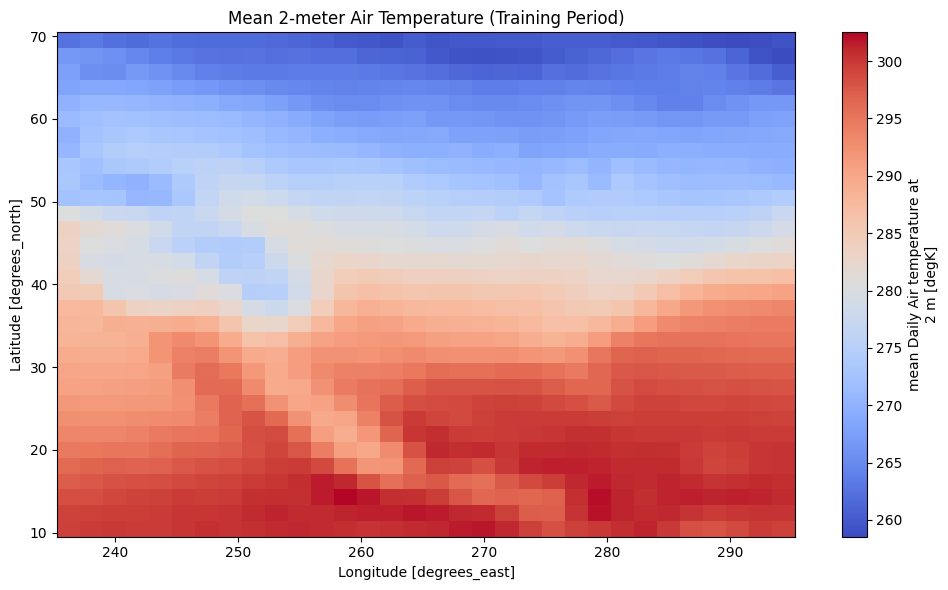

In [16]:
# Visualize mean temperature field
fig, ax = plt.subplots(figsize=(10, 6))
ds_train.mean(dim='time').air.plot(ax=ax, cmap='coolwarm')
ax.set_title("Mean 2-meter Air Temperature (Training Period)")
plt.tight_layout()
plt.show()

## 3. Dataset and DataLoader Setup

We'll create a PyTorch Dataset that:
1. Extracts daily snapshots from the xarray dataset
2. Normalizes the data to [0, 1] range (or [-1, 1] for some models)
3. Reshapes to the format expected by UNet2D: `[C, H, W]`


In [17]:
# Create datasets
train_data = ds_train.air.values
valid_data = ds_valid.air.values
test_data = ds_test.air.values

# Normalize using training data statistics
data_min, data_max = train_data.min(), train_data.max()

train_dataset = WeatherDataset(train_data, normalize=(data_min, data_max)) # min-min, mu-sigma, any other
valid_dataset = WeatherDataset(valid_data, normalize=(data_min, data_max))
test_dataset = WeatherDataset(test_data, normalize=(data_min, data_max))

Dataset shape: (1461, 32, 32)
Value range: [0.000, 1.000] (normalized)
Original range: [217.02, 313.00] (original units)
Dataset shape: (366, 32, 32)
Value range: [-0.028, 0.971] (normalized)
Original range: [217.02, 313.00] (original units)
Dataset shape: (365, 32, 32)
Value range: [0.039, 0.987] (normalized)
Original range: [217.02, 313.00] (original units)


In [18]:
# Create DataLoaders
batch_size = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

# Check a batch
sample_batch = next(iter(train_loader))
print(f"Batch shape: {sample_batch.shape}")  # Should be [batch_size, 1, H, W]

/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Batch shape: torch.Size([16, 1, 32, 32])


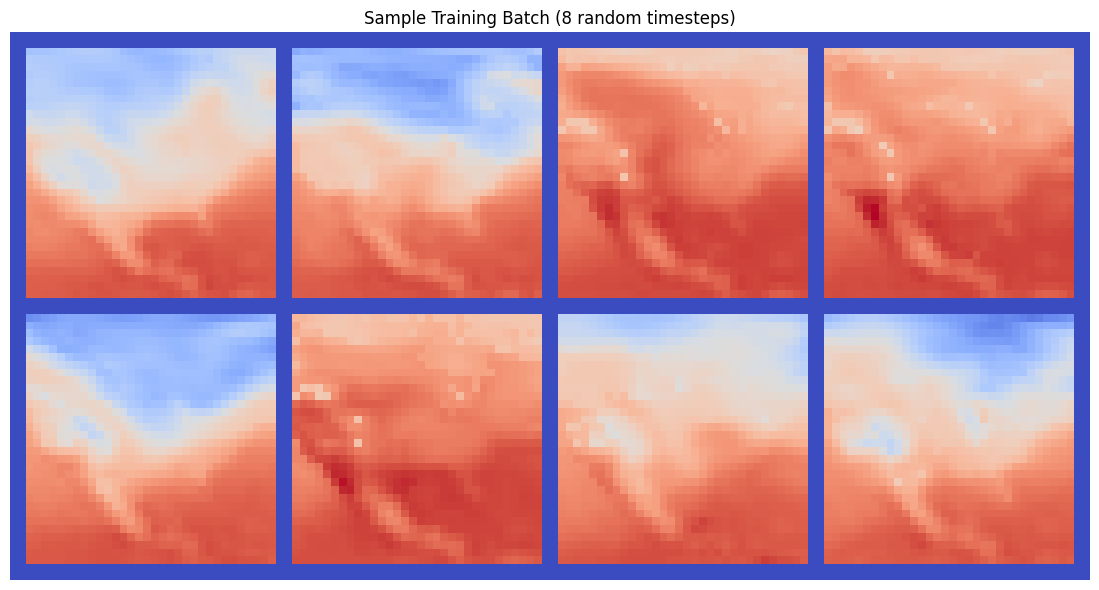

In [19]:
# Visualize a batch of training samples
import torchvision

fig, ax = plt.subplots(figsize=(12, 6))
grid = torchvision.utils.make_grid(sample_batch[:8], nrow=4, padding=2)
ax.imshow(grid[0].cpu().numpy(), cmap='coolwarm')
ax.set_title("Sample Training Batch (8 random timesteps)")
ax.axis('off')
plt.tight_layout()
plt.show()


## 4. Model and Scheduler Setup

We'll use a UNet2D model from diffusers with an EDM-style (Elucidating the Design Space of Diffusion-Based Generative Models) scheduler. The model learns to predict noise at different timesteps.


In [20]:
# Determine image size from data
# img_h and img_w will now reflect the padded dimensions from the DataLoader
_, _, img_h, img_w = sample_batch.shape
print(f"Image size for model input: height={img_h}, width={img_w}")

Image size for model input: height=32, width=32


In [21]:
# Not required as it is now in the library

# # Initialize noise scheduler (EDM-style with Heun discretization)
# num_train_timesteps = 1000
# noise_scheduler = HeunDiscreteScheduler(num_train_timesteps=num_train_timesteps)

# print(f"Scheduler: {type(noise_scheduler).__name__}")
# print(f"Number of training timesteps: {num_train_timesteps}")


In [22]:
from deepassimilate import build_scheduler

# EDM-style scheduler (Heun discretization)
noise_scheduler = build_scheduler(name="heun_edm", num_train_timesteps=1000)

# # DDPM scheduler
# noise_scheduler = build_scheduler(name="ddpm", num_train_timesteps=1000)

# # DDIM scheduler
# noise_scheduler = build_scheduler(name="ddim", num_train_timesteps=1000)

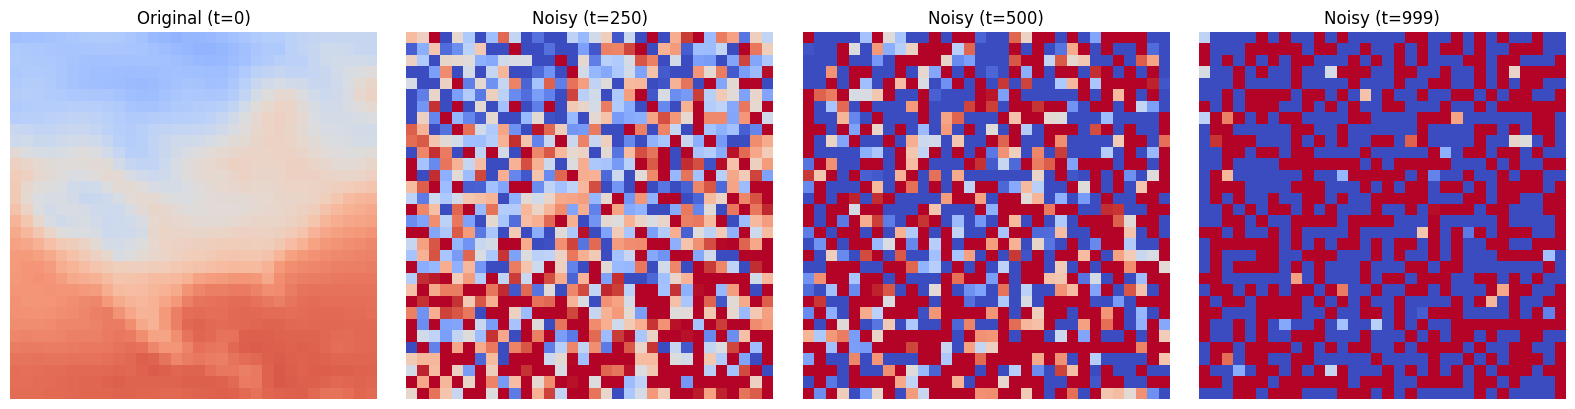

In [23]:
# Visualize the noising process
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

sample = sample_batch[0:1].to(device)  # [1, 1, H, W]

# Map to [-1, 1] for visualization (EDM schedulers typically work in this range)
sample = sample * 2.0 - 1.0

# Show original
axs[0].imshow(sample[0, 0].cpu().numpy(), cmap='coolwarm', vmin=-1, vmax=1)
axs[0].set_title('Original (t=0)')
axs[0].axis('off')

# Add noise at different timesteps
for i, timestep in enumerate([250, 500, 999]):
    noise = torch.randn_like(sample)
    timesteps = torch.tensor([timestep], device=device)
    noisy = noise_scheduler.add_noise(sample, noise, timesteps)

    axs[i+1].imshow(noisy[0, 0].cpu().numpy(), cmap='coolwarm', vmin=-1, vmax=1)
    axs[i+1].set_title(f'Noisy (t={timestep})')
    axs[i+1].axis('off')

plt.tight_layout()
plt.show()

In [24]:
# Not required now as it is a part of the library
# # Initialize UNet2D model
# # Using a configuration similar to EDM models
# model = UNet2DModel(
#     sample_size=img_size,
#     in_channels=1,
#     out_channels=1,
#     layers_per_block=2,
#     block_out_channels=(64, 128, 256, 512),
#     down_block_types=(
#         "DownBlock2D",
#         "AttnDownBlock2D",  # Attention layers help with spatial relationships
#         "AttnDownBlock2D",
#         "DownBlock2D",
#     ),
#     up_block_types=(
#         "UpBlock2D",
#         "AttnUpBlock2D",
#         "AttnUpBlock2D",
#         "UpBlock2D",
#     ),
#     time_embedding_type="positional",  # or "fourier" for EDM-style
# ).to(device)

# # Count parameters
# num_params = sum(p.numel() for p in model.parameters())
# print(f"Model initialized with {num_params:,} parameters")
# print(f"Model architecture: {type(model).__name__}")


In [25]:
# Initialize UNet2D model using deepassimilate utility
model = build_unet_2d(
    architecture="edm_unet_2d",  # or "basic_unet"
    img_size=img_h,
    in_channels=1,
    out_channels=1
).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Model initialized with {num_params:,} parameters")
print(f"Model architecture: {type(model).__name__}")
print(f"Available architectures: 'edm_unet_2d', 'basic_unet', 'custom'")

Model initialized with 34,488,961 parameters
Model architecture: UNet2DModel
Available architectures: 'edm_unet_2d', 'basic_unet', 'custom'


## 5. Training Loop

The training objective is to predict the noise that was added to the data:
$$L = \\|\\epsilon - \\epsilon_\\theta(x_t, t)\\|^2$$

where $x_t$ is the noisy input at timestep $t$, $\\epsilon$ is the true noise, and $\\epsilon_\\theta$ is the model prediction.


In [26]:
# Training configuration
num_epochs = 1000
learning_rate = 1e-4
weight_decay = 1e-2

# Loss function
loss_fn = nn.MSELoss()

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

# Learning rate scheduler (cosine annealing)
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=num_training_steps,
    eta_min=1e-6
)

print(f"Training for {num_epochs} epochs")
print(f"Steps per epoch: {len(train_loader)}")
print(f"Total training steps: {num_training_steps}")

Training for 1000 epochs
Steps per epoch: 92
Total training steps: 92000


In [27]:
# # Training loop with validation
# # This detailed loop includes validation, checkpointing, and progress tracking
# # For a simpler approach, use da.train_unconditional() - see 'Next Steps' section
# train_losses = []
# val_losses = []

# best_val_loss = float('inf')
# checkpoint_dir = 'checkpoints'
# os.makedirs(checkpoint_dir, exist_ok=True)

# for epoch in range(num_epochs):
#     # Training phase
#     model.train()
#     epoch_train_losses = []

#     train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
#     for batch_idx, batch in enumerate(train_pbar):
#         x = batch.to(device)  # [B, 1, H, W]

#         # Check for NaN in input
#         if torch.isnan(x).any():
#             print(f"⚠️ Warning: NaN detected in input batch {batch_idx}, skipping...")
#             continue

#         # Map to [-1, 1] for EDM-style training
#         x = x * 2.0 - 1.0

#         # Clip to prevent extreme values
#         x = torch.clamp(x, min=-3.0, max=3.0)

#         # Sample random timesteps
#         timesteps = torch.randint(
#             0,
#             noise_scheduler.num_train_timesteps,
#             (x.shape[0],),
#             device=device
#         ).long()

#         # Add noise
#         noise = torch.randn_like(x)
#         noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

#         # Check for NaN after adding noise
#         if torch.isnan(noisy_x).any():
#             print(f"⚠️ Warning: NaN after adding noise in batch {batch_idx}, skipping...")
#             continue

#         # Predict noise
#         pred_noise = model(noisy_x, timesteps).sample

#         # Check for NaN in predictions
#         if torch.isnan(pred_noise).any():
#             print(f"⚠️ Warning: NaN in model predictions at batch {batch_idx}, skipping...")
#             continue

#         # Compute loss
#         loss = loss_fn(pred_noise, noise)

#         # Check for NaN in loss
#         if torch.isnan(loss) or torch.isinf(loss):
#             print(f"⚠️ Warning: NaN/Inf loss detected at batch {batch_idx}, skipping...")
#             continue

#         # Backward pass
#         optimizer.zero_grad()
#         loss.backward()

#         # Check for NaN gradients before clipping
#         has_nan_grad = False
#         for param in model.parameters():
#             if param.grad is not None and torch.isnan(param.grad).any():
#                 has_nan_grad = True
#                 break

#         if has_nan_grad:
#             print(f"⚠️ Warning: NaN gradients detected at batch {batch_idx}, skipping update...")
#             optimizer.zero_grad()  # Clear gradients
#             continue

#         # Gradient clipping (more aggressive to prevent instability)
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

#         optimizer.step()
#         lr_scheduler.step()

#         # Only track valid losses
#         loss_value = loss.item()
#         if not (np.isnan(loss_value) or np.isinf(loss_value)):
#             epoch_train_losses.append(loss_value)
#             train_pbar.set_postfix({'loss': f"{loss_value:.4f}"})
#         else:
#             train_pbar.set_postfix({'loss': 'NaN/Inf - skipped'})

#     # Only compute average if we have valid losses
#     if len(epoch_train_losses) > 0:
#         avg_train_loss = np.mean(epoch_train_losses)
#     else:
#         print(f"⚠️ Warning: No valid training losses in epoch {epoch+1}, stopping training!")
#         break

#     train_losses.append(avg_train_loss)

#     # Validation phase
#     model.eval()
#     epoch_val_losses = []

#     with torch.no_grad():
#         val_pbar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]")
#         for batch in val_pbar:
#             x = batch.to(device)
#             x = x * 2.0 - 1.0
#             x = torch.clamp(x, min=-3.0, max=3.0)  # Clip validation data too

#             timesteps = torch.randint(
#                 0,
#                 noise_scheduler.num_train_timesteps,
#                 (x.shape[0],),
#                 device=device
#             ).long()

#             noise = torch.randn_like(x)
#             noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
#             pred_noise = model(noisy_x, timesteps).sample
#             loss = loss_fn(pred_noise, noise)

#             loss_value = loss.item()
#             if not (np.isnan(loss_value) or np.isinf(loss_value)):
#                 epoch_val_losses.append(loss_value)
#                 val_pbar.set_postfix({'loss': f"{loss_value:.4f}"})

#     # Only compute average if we have valid losses
#     if len(epoch_val_losses) > 0:
#         avg_val_loss = np.mean(epoch_val_losses)
#     else:
#         print(f"⚠️ Warning: No valid validation losses in epoch {epoch+1}")
#         avg_val_loss = float('inf')

#     val_losses.append(avg_val_loss)

#     # Print epoch summary
#     print(f"\nEpoch {epoch+1}/{num_epochs}:")
#     print(f"  Train Loss: {avg_train_loss:.6f}")
#     print(f"  Val Loss: {avg_val_loss:.6f}")

#     # Check if loss is still valid before saving
#     if not (np.isnan(avg_val_loss) or np.isinf(avg_val_loss)) and avg_val_loss < best_val_loss:
#         best_val_loss = avg_val_loss
#         checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pth')
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'val_loss': avg_val_loss,
#             'train_losses': train_losses,
#             'val_losses': val_losses,
#         }, checkpoint_path)
#         print(f"  ✓ Saved best model (val_loss={avg_val_loss:.6f})")
#     elif np.isnan(avg_val_loss) or np.isinf(avg_val_loss):
#         print(f"  ⚠️ Warning: Invalid loss detected, not saving model")

#     # Early stopping if loss becomes NaN
#     if np.isnan(avg_train_loss) or np.isinf(avg_train_loss):
#         print(f"\n⚠️ Training stopped due to NaN/Inf loss at epoch {epoch+1}")
#         print("   Try: reducing learning rate, checking data normalization, or reducing model size")
#         break

#     print('-' * 50)


In [28]:
# Pre-training diagnostics: Check for common NaN causes
# Run this cell before training to identify potential issues

print("=" * 60)
print("🔍 PRE-TRAINING DIAGNOSTICS")
print("=" * 60)

# 1. Check data for NaN/inf
print("\n1. Checking training data...")
sample_batch = next(iter(train_loader))
has_nan_data = torch.isnan(sample_batch).any().item()
has_inf_data = torch.isinf(sample_batch).any().item()
print(f"   - NaN in data: {has_nan_data}")
print(f"   - Inf in data: {has_inf_data}")
print(f"   - Data shape: {sample_batch.shape}")
print(f"   - Data range: [{sample_batch.min():.4f}, {sample_batch.max():.4f}]")
print(f"   - Data mean: {sample_batch.mean():.4f}, std: {sample_batch.std():.4f}")

# 2. Check model parameters
print("\n2. Checking model initialization...")
model_params_ok = True
total_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        total_params += param.numel()
        if torch.isnan(param).any():
            print(f"   ⚠️ Warning: NaN found in {name}")
            model_params_ok = False
        if torch.isinf(param).any():
            print(f"   ⚠️ Warning: Inf found in {name}")
            model_params_ok = False
print(f"   - Model parameters OK: {model_params_ok}")
print(f"   - Total trainable parameters: {total_params:,}")

# 3. Test forward pass
print("\n3. Testing forward pass...")
model.eval()
with torch.no_grad():
    test_input = sample_batch[:2].to(device)  # Small batch
    test_input = test_input * 2.0 - 1.0  # Map to [-1, 1]
    test_timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (2,), device=device).long()
    test_noise = torch.randn_like(test_input)
    test_noisy = noise_scheduler.add_noise(test_input, test_noise, test_timesteps)
    test_pred = model(test_noisy, test_timesteps).sample

    has_nan_pred = torch.isnan(test_pred).any().item()
    has_inf_pred = torch.isinf(test_pred).any().item()
    print(f"   - NaN in predictions: {has_nan_pred}")
    print(f"   - Inf in predictions: {has_inf_pred}")
    if not (has_nan_pred or has_inf_pred):
        print(f"   - Prediction range: [{test_pred.min():.4f}, {test_pred.max():.4f}]")
        test_loss = loss_fn(test_pred, test_noise)
        print(f"   - Test loss: {test_loss.item():.4f}")

# 4. Check training configuration
print("\n4. Checking training configuration...")
print(f"   - Learning rate: {learning_rate:.2e}")
print(f"   - Batch size: {batch_size}")
print(f"   - Number of epochs: {num_epochs}")
print(f"   - Gradient clipping: enabled (max_norm=1.0)")

# 5. Recommendations
print("\n" + "=" * 60)
print("💡 RECOMMENDATIONS:")
print("=" * 60)

if has_nan_data or has_inf_data:
    print("   ⚠️ CRITICAL: Data contains NaN/Inf! Check data loading and preprocessing.")

if has_nan_pred or has_inf_pred:
    print("   ⚠️ CRITICAL: Model produces NaN/Inf! Possible causes:")
    print("      - Learning rate too high (try 1e-5 or 5e-6)")
    print("      - Model too large for data size")
    print("      - Numerical instability in scheduler")
    print("      - Try reducing learning rate or using a smaller model")

if learning_rate > 1e-3:
    print("   ⚠️ Learning rate may be too high. Try reducing to 1e-4 or lower.")

if sample_batch.std() < 0.01 or sample_batch.std() > 100:
    print("   ⚠️ Data variance seems unusual. Check normalization.")

if not (has_nan_data or has_inf_data or has_nan_pred or has_inf_pred):
    print("   ✓ All checks passed! Training should proceed normally.")
    print("   If NaN appears during training, it's likely due to:")
    print("      - Learning rate too high (most common)")
    print("      - Gradient explosion")
    print("      - Model instability")

print("=" * 60)


🔍 PRE-TRAINING DIAGNOSTICS

1. Checking training data...


/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


   - NaN in data: False
   - Inf in data: False
   - Data shape: torch.Size([16, 1, 32, 32])
   - Data range: [0.0294, 0.9453]
   - Data mean: 0.7071, std: 0.1624

2. Checking model initialization...
   - Model parameters OK: True
   - Total trainable parameters: 34,488,833

3. Testing forward pass...


/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'HeunDiscreteScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'HeunDiscreteScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


   - NaN in predictions: False
   - Inf in predictions: False
   - Prediction range: [-0.0091, 0.0068]
   - Test loss: 1.0622

4. Checking training configuration...
   - Learning rate: 1.00e-04
   - Batch size: 16
   - Number of epochs: 1000
   - Gradient clipping: enabled (max_norm=1.0)

💡 RECOMMENDATIONS:
   ✓ All checks passed! Training should proceed normally.
   If NaN appears during training, it's likely due to:
      - Learning rate too high (most common)
      - Gradient explosion
      - Model instability


In [29]:
# Helper function to generate and visualize samples during training
def generate_and_visualize_samples(
    model,
    scheduler,
    device,
    num_samples=4,
    num_inference_steps=50,
    img_h=None,
    img_w=None,
    data_min=None,
    data_max=None,
    epoch=None,
    save_dir=None
):
    """
    Generate samples from the model and create a visualization.

    Args:
        model: The diffusion model
        scheduler: The noise scheduler
        device: Device to run on
        num_samples: Number of samples to generate
        num_inference_steps: Number of denoising steps
        img_h, img_w: Image dimensions
        data_min, data_max: Data normalization range (for denormalization)
        epoch: Current epoch (for title)
        save_dir: Directory to save visualization (optional)
    """
    model.eval()

    # Use model's expected input size if dimensions not provided
    if img_h is None or img_w is None:
        # Try to infer from a test forward pass
        test_shape = (1, 1, 64, 64)  # Default fallback
    else:
        test_shape = (num_samples, 1, img_h, img_w)

    with torch.no_grad():
        # Set timesteps for inference
        scheduler.set_timesteps(num_inference_steps, device=device)

        # Start from random noise
        samples = torch.randn(test_shape, device=device)

        # Denoising loop
        for t in scheduler.timesteps:
            timestep = t.expand(samples.shape[0])
            noise_pred = model(samples, timestep).sample
            samples = scheduler.step(noise_pred, t, samples).prev_sample

        # Denormalization: Two-step process
        # Step 1: Map from EDM training range [-1, 1] back to normalized [0, 1]
        # This is the inverse of: x = x * 2.0 - 1.0 (used during training)
        samples = (samples + 1.0) / 2.0  # [-1, 1] -> [0, 1]

        # Step 2: Map from normalized [0, 1] back to original data scale
        # This is the inverse of: (data - data_min) / (data_max - data_min)
        if data_min is not None and data_max is not None:
            samples = samples * (data_max - data_min) + data_min  # [0, 1] -> [data_min, data_max]

        # Create visualization
        fig, axs = plt.subplots(1, num_samples, figsize=(4*num_samples, 4))
        if num_samples == 1:
            axs = [axs]

        for i in range(num_samples):
            sample_img = samples[i, 0].cpu().numpy()
            im = axs[i].imshow(sample_img, cmap='coolwarm')
            title = f'Sample {i+1}'
            if epoch is not None:
                title = f'Epoch {epoch+1}: {title}'
            axs[i].set_title(title)
            axs[i].axis('off')
            plt.colorbar(im, ax=axs[i], fraction=0.046)

        plt.tight_layout()

        # Save if directory provided
        if save_dir is not None and epoch is not None:
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f'samples_epoch_{epoch+1:03d}.png')
            plt.savefig(save_path, dpi=100, bbox_inches='tight')

        plt.show()
        plt.close()

        return samples

    model.train()  # Set back to training mode

print("✓ Sampling and visualization helper function defined")
print("  This will be used to generate samples during training")

✓ Sampling and visualization helper function defined
  This will be used to generate samples during training


# Put this inside DeepAssimilate

In [30]:
# Put this inside DeepAssimilate

# Training configuration
# These settings can be customized based on your needs
num_epochs = 1000
learning_rate = 1e-4
weight_decay = 1e-2

# Loss function (MSE loss for noise prediction)
loss_fn = nn.MSELoss()

# Optimizer (AdamW is a good default for diffusion models)
optimizer = optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

# Learning rate scheduler (cosine annealing - gradually reduce learning rate)
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=num_training_steps,
    eta_min=1e-6
)

print(f"Training for {num_epochs} epochs")
print(f"Steps per epoch: {len(train_loader)}")
print(f"Total training steps: {num_training_steps}")
print(f"Learning rate: {learning_rate}")
print(f"\n💡 Tip: This is standard PyTorch training setup. Keep it as-is for full control.")
print(f"   For a simpler approach, use da.train_unconditional() - see 'Next Steps' section.")

Training for 1000 epochs
Steps per epoch: 92
Total training steps: 92000
Learning rate: 0.0001

💡 Tip: This is standard PyTorch training setup. Keep it as-is for full control.
   For a simpler approach, use da.train_unconditional() - see 'Next Steps' section.


In [31]:
# Improved visualization function with better debugging and scaling
# This version will be used to replace the existing one if needed
def generate_and_visualize_samples_v2(
    model, scheduler, device, num_samples=4, num_inference_steps=50,
    img_h=None, img_w=None, data_min=None, data_max=None, epoch=None, save_dir=None
):
    """Improved version with better debugging and visualization scaling."""
    model.eval()

    if img_h is None or img_w is None:
        test_shape = (1, 1, 64, 64)
    else:
        test_shape = (num_samples, 1, img_h, img_w)

    with torch.no_grad():
        original_num_train_timesteps = scheduler.config.num_train_timesteps
        scheduler.set_timesteps(num_inference_steps, device=device)

        samples = torch.randn(test_shape, device=device)

        # Denoising loop
        for t in scheduler.timesteps:
            timestep = t.expand(samples.shape[0])
            noise_pred = model(samples, timestep).sample

            # Handle NaN
            if torch.isnan(noise_pred).any():
                noise_pred = torch.nan_to_num(noise_pred, nan=0.0)

            samples = scheduler.step(noise_pred, t, samples).prev_sample
            if torch.isnan(samples).any():
                samples = torch.nan_to_num(samples, nan=0.0)

        scheduler.set_timesteps(original_num_train_timesteps, device=device)

        # Denormalize
        samples = (samples + 1.0) / 2.0
        if data_min is not None and data_max is not None:
            samples = samples * (data_max - data_min) + data_min

        samples = torch.nan_to_num(samples, nan=0.0)
        samples_np = samples.cpu().numpy()

        # Debug output
        print(f"   📊 Sample stats: min={samples_np.min():.6f}, max={samples_np.max():.6f}, mean={samples_np.mean():.6f}, std={samples_np.std():.6f}")

        # Calculate visualization range using percentiles
        valid = samples_np[~np.isnan(samples_np)]
        if len(valid) > 0 and valid.std() > 1e-10:
            vmin, vmax = np.percentile(valid, [5, 95])
            abs_max = max(abs(vmin), abs(vmax))
            vmin, vmax = -abs_max, abs_max if abs_max > 1e-10 else (-1, 1)
        else:
            vmin, vmax = (data_min, data_max) if (data_min is not None and data_max is not None) else (-1, 1)

        # Visualize
        fig, axs = plt.subplots(1, num_samples, figsize=(4*num_samples, 4))
        if num_samples == 1:
            axs = [axs]

        for i in range(num_samples):
            im = axs[i].imshow(samples_np[i, 0], cmap='coolwarm', vmin=260, vmax=300)
            title = f'Epoch {epoch+1}: Sample {i+1}' if epoch is not None else f'Sample {i+1}'
            axs[i].set_title(title)
            axs[i].axis('off')
            plt.colorbar(im, ax=axs[i], fraction=0.046)

        plt.tight_layout()

        if save_dir and epoch is not None:
            os.makedirs(save_dir, exist_ok=True)
            plt.savefig(os.path.join(save_dir, f'samples_epoch_{epoch+1:03d}.png'), dpi=100, bbox_inches='tight')

        plt.show()
        plt.close()

        return samples

    model.train()

print("✓ Improved visualization function v2 available (use this if samples appear white/blank)")


✓ Improved visualization function v2 available (use this if samples appear white/blank)


📊 Visualization: Generating 4 samples every 5 epoch(s)
   Samples will be saved to: checkpoints/samples

🔧 Initializing scheduler for training (num_train_timesteps=1000)...
   ✓ Scheduler initialized and ready for training


Epoch 1/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 1/1000 [Train]:  47%|████▋     | 43/92 [00:19<00:12,  3.97it/s, loss=0.9752]

⚠️ Warning: NaN in model predictions at batch 43, skipping...


Epoch 1/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 1/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.51it/s, loss=0.9547]



Epoch 1/1000:
  Train Loss: 0.972978
  Val Loss: 0.967984
  ✓ Saved best model (val_loss=0.967984)
--------------------------------------------------


Epoch 2/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 2/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 2/1000


Epoch 2/1000:
  Train Loss: 0.964808
  Val Loss: 0.973838
--------------------------------------------------


Epoch 3/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 3/1000 [Train]:  93%|█████████▎| 86/92 [00:25<00:01,  3.92it/s, loss=0.9837]

⚠️ Warning: NaN in model predictions at batch 86, skipping...


Epoch 3/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 3/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.57it/s, loss=0.9811]



Epoch 3/1000:
  Train Loss: 0.945892
  Val Loss: 0.943397
  ✓ Saved best model (val_loss=0.943397)
--------------------------------------------------


Epoch 4/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 4/1000 [Train]:  61%|██████    | 56/92 [00:17<00:09,  3.91it/s, loss=0.9263]

⚠️ Warning: NaN in model predictions at batch 56, skipping...


Epoch 4/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 4/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, loss=0.9003]



Epoch 4/1000:
  Train Loss: 0.935083
  Val Loss: 0.932615
  ✓ Saved best model (val_loss=0.932615)
--------------------------------------------------


Epoch 5/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 5/1000 [Train]:  34%|███▎      | 31/92 [00:11<00:15,  3.83it/s, loss=0.9111]

⚠️ Warning: NaN in model predictions at batch 31, skipping...


Epoch 5/1000 [Train]:  38%|███▊      | 35/92 [00:12<00:13,  4.22it/s, loss=0.9407]

⚠️ Warning: NaN in model predictions at batch 35, skipping...


Epoch 5/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 5/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.55it/s, loss=0.9352]



Epoch 5/1000:
  Train Loss: 0.932712
  Val Loss: 0.927227
  ✓ Saved best model (val_loss=0.927227)

🎨 Generating samples at epoch 5...


/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


   📊 Sample stats: min=162.536072, max=371.496674, mean=265.226929, std=29.261740


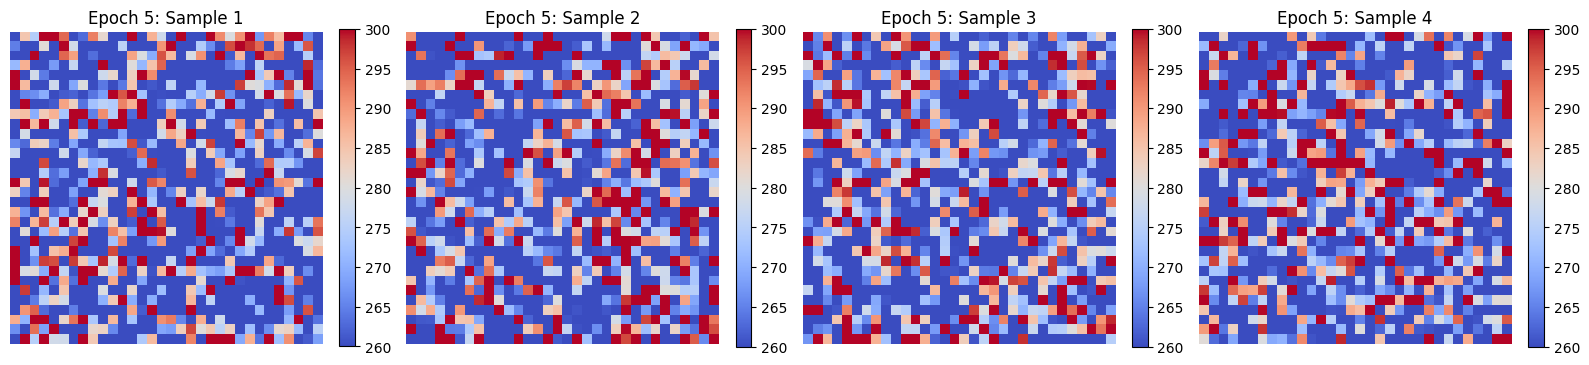

   ✓ Samples saved to checkpoints/samples/samples_epoch_005.png
--------------------------------------------------


Epoch 6/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 6/1000 [Train]:   9%|▊         | 8/92 [00:05<00:28,  2.95it/s, loss=0.9605]

⚠️ Warning: NaN in model predictions at batch 8, skipping...


Epoch 6/1000 [Train]:  37%|███▋      | 34/92 [00:11<00:15,  3.84it/s, loss=0.8789]

⚠️ Warning: NaN in model predictions at batch 34, skipping...


Epoch 6/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 6/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.9069]



Epoch 6/1000:
  Train Loss: 0.914091
  Val Loss: 0.910316
  ✓ Saved best model (val_loss=0.910316)
--------------------------------------------------


Epoch 7/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 7/1000 [Train]:  39%|███▉      | 36/92 [00:13<00:14,  3.86it/s, loss=0.8929]

⚠️ Warning: NaN in model predictions at batch 36, skipping...


Epoch 7/1000 [Train]:  82%|████████▏ | 75/92 [00:23<00:04,  3.91it/s, loss=0.8792]

⚠️ Warning: NaN in model predictions at batch 75, skipping...


Epoch 7/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 7/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.9497]



Epoch 7/1000:
  Train Loss: 0.905046
  Val Loss: 0.900229
  ✓ Saved best model (val_loss=0.900229)
--------------------------------------------------


Epoch 8/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 8/1000 [Train]:  55%|█████▌    | 51/92 [00:16<00:10,  3.92it/s, loss=0.7712]

⚠️ Warning: NaN in model predictions at batch 51, skipping...


Epoch 8/1000 [Train]:  70%|██████▉   | 64/92 [00:19<00:07,  3.95it/s, loss=0.8942]

⚠️ Warning: NaN in model predictions at batch 64, skipping...


Epoch 8/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 8/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.54it/s, loss=0.9190]



Epoch 8/1000:
  Train Loss: 0.889781
  Val Loss: 0.881939
  ✓ Saved best model (val_loss=0.881939)
--------------------------------------------------


Epoch 9/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 9/1000 [Train]:   2%|▏         | 2/92 [00:03<02:29,  1.66s/it, loss=0.8769]

⚠️ Warning: NaN in model predictions at batch 2, skipping...


Epoch 9/1000 [Train]:  55%|█████▌    | 51/92 [00:16<00:10,  3.91it/s, loss=0.8312]

⚠️ Warning: NaN in model predictions at batch 51, skipping...


Epoch 9/1000 [Train]:  61%|██████    | 56/92 [00:17<00:08,  4.16it/s, loss=0.9539]

⚠️ Warning: NaN in model predictions at batch 56, skipping...


Epoch 9/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 9/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.9308]



Epoch 9/1000:
  Train Loss: 0.883331
  Val Loss: 0.866111
  ✓ Saved best model (val_loss=0.866111)
--------------------------------------------------


Epoch 10/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 10/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 10/1


Epoch 10/1000:
  Train Loss: 0.870777
  Val Loss: 0.849283
  ✓ Saved best model (val_loss=0.849283)

🎨 Generating samples at epoch 10...


/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


   📊 Sample stats: min=171.965698, max=326.701996, mean=265.373718, std=15.052555


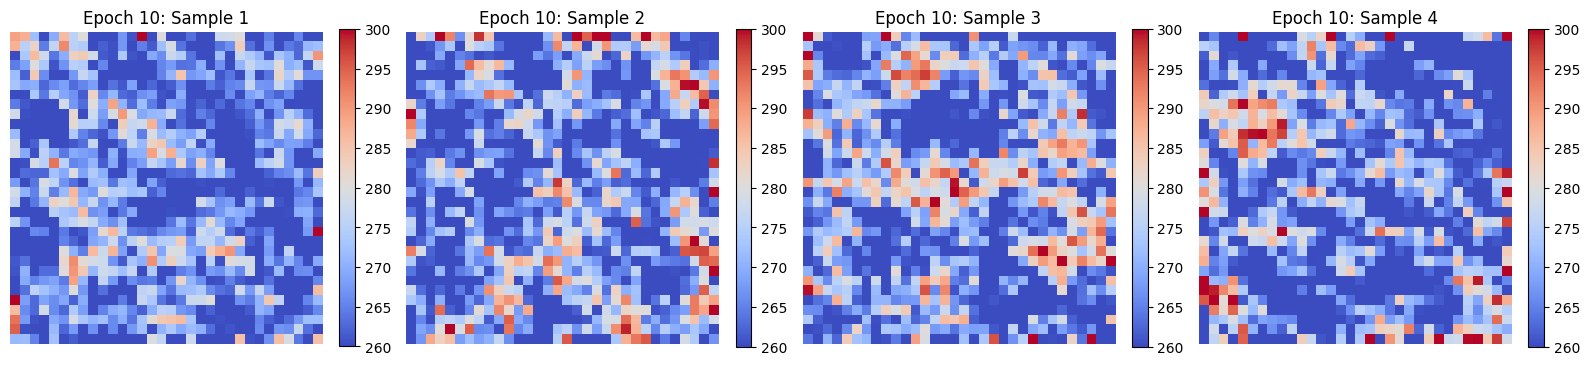

   ✓ Samples saved to checkpoints/samples/samples_epoch_010.png
--------------------------------------------------


Epoch 11/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 11/1000 [Train]:   7%|▋         | 6/92 [00:04<00:38,  2.23it/s, loss=0.9206]

⚠️ Warning: NaN in model predictions at batch 6, skipping...


Epoch 11/1000 [Train]:  24%|██▍       | 22/92 [00:08<00:17,  3.99it/s, loss=0.8807]

⚠️ Warning: NaN in model predictions at batch 22, skipping...


Epoch 11/1000 [Train]:  62%|██████▏   | 57/92 [00:17<00:08,  4.00it/s, loss=0.8997]

⚠️ Warning: NaN in model predictions at batch 57, skipping...


Epoch 11/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 11/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.9021]



Epoch 11/1000:
  Train Loss: 0.853480
  Val Loss: 0.838588
  ✓ Saved best model (val_loss=0.838588)
--------------------------------------------------


Epoch 12/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 12/1000 [Train]:  16%|█▋        | 15/92 [00:07<00:19,  3.88it/s, loss=0.8137]

⚠️ Warning: NaN in model predictions at batch 15, skipping...


Epoch 12/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 12/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.53it/s, loss=0.7928]



Epoch 12/1000:
  Train Loss: 0.843496
  Val Loss: 0.828406
  ✓ Saved best model (val_loss=0.828406)
--------------------------------------------------


Epoch 13/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 13/1000 [Train]:  20%|█▉        | 18/92 [00:07<00:19,  3.89it/s, loss=0.8773]

⚠️ Warning: NaN in model predictions at batch 18, skipping...


Epoch 13/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 13/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.8970]



Epoch 13/1000:
  Train Loss: 0.840693
  Val Loss: 0.844193
--------------------------------------------------


Epoch 14/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 14/1000 [Train]:  60%|█████▉    | 55/92 [00:17<00:09,  3.90it/s, loss=0.7374]

⚠️ Warning: NaN in model predictions at batch 55, skipping...


Epoch 14/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 14/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.8141]



Epoch 14/1000:
  Train Loss: 0.813993
  Val Loss: 0.802915
  ✓ Saved best model (val_loss=0.802915)
--------------------------------------------------


Epoch 15/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 15/1000 [Train]:   8%|▊         | 7/92 [00:06<00:36,  2.35it/s, loss=0.8739]

⚠️ Warning: NaN in model predictions at batch 7, skipping...


Epoch 15/1000 [Train]:  88%|████████▊ | 81/92 [00:24<00:02,  3.89it/s, loss=0.8555]

⚠️ Warning: NaN in model predictions at batch 81, skipping...


Epoch 15/1000 [Train]:  91%|█████████▏| 84/92 [00:25<00:01,  4.49it/s, loss=0.7489]

⚠️ Warning: NaN in model predictions at batch 84, skipping...


Epoch 15/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 15/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, loss=0.8410]


Epoch 15/1000:
  Train Loss: 0.810195
  Val Loss: 0.809537

🎨 Generating samples at epoch 15...



/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


   📊 Sample stats: min=234.870483, max=291.154785, mean=265.889587, std=6.783273


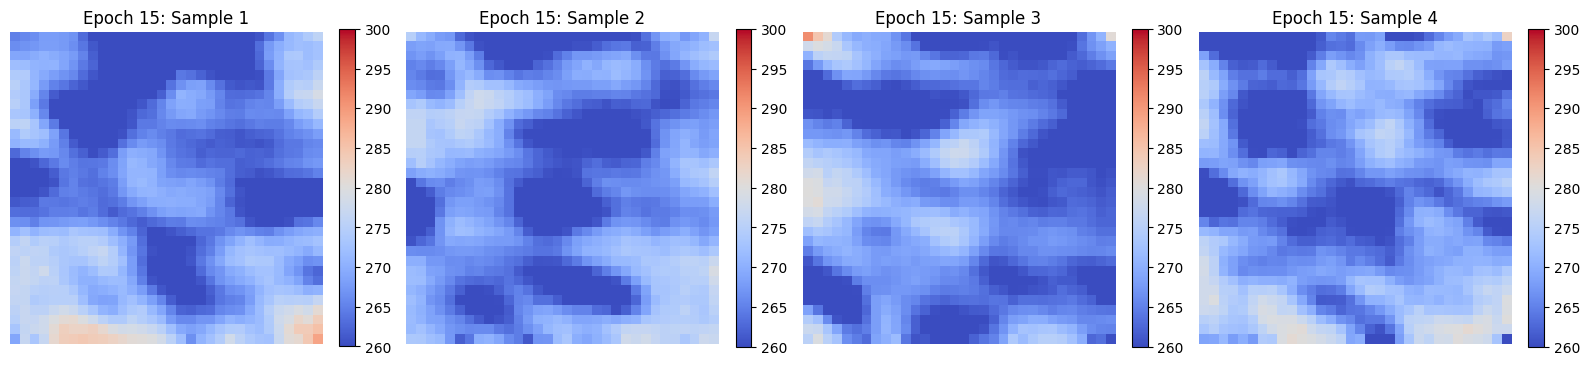

   ✓ Samples saved to checkpoints/samples/samples_epoch_015.png
--------------------------------------------------


Epoch 16/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 16/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 16/1


Epoch 16/1000:
  Train Loss: 0.803613
  Val Loss: 0.795219
  ✓ Saved best model (val_loss=0.795219)
--------------------------------------------------


Epoch 17/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 17/1000 [Train]:  13%|█▎        | 12/92 [00:07<00:22,  3.52it/s, loss=0.8184]

⚠️ Warning: NaN in model predictions at batch 12, skipping...


Epoch 17/1000 [Train]:  70%|██████▉   | 64/92 [00:20<00:07,  3.92it/s, loss=0.7879]

⚠️ Warning: NaN in model predictions at batch 64, skipping...


Epoch 17/1000 [Train]:  74%|███████▍  | 68/92 [00:21<00:05,  4.33it/s, loss=0.6844]

⚠️ Warning: NaN in model predictions at batch 68, skipping...


Epoch 17/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 17/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.7241]



Epoch 17/1000:
  Train Loss: 0.788238
  Val Loss: 0.788615
  ✓ Saved best model (val_loss=0.788615)
--------------------------------------------------


Epoch 18/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 18/1000 [Train]:  71%|███████   | 65/92 [00:20<00:06,  3.91it/s, loss=0.7133]

⚠️ Warning: NaN in model predictions at batch 65, skipping...


Epoch 18/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 18/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, loss=0.8475]



Epoch 18/1000:
  Train Loss: 0.779927
  Val Loss: 0.780943
  ✓ Saved best model (val_loss=0.780943)
--------------------------------------------------


Epoch 19/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 19/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 19/1


Epoch 19/1000:
  Train Loss: 0.767180
  Val Loss: 0.768849
  ✓ Saved best model (val_loss=0.768849)
--------------------------------------------------


Epoch 20/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 20/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 20/1


Epoch 20/1000:
  Train Loss: 0.761154
  Val Loss: 0.749855
  ✓ Saved best model (val_loss=0.749855)

🎨 Generating samples at epoch 20...


/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


   📊 Sample stats: min=244.243668, max=287.255737, mean=266.065430, std=7.801453


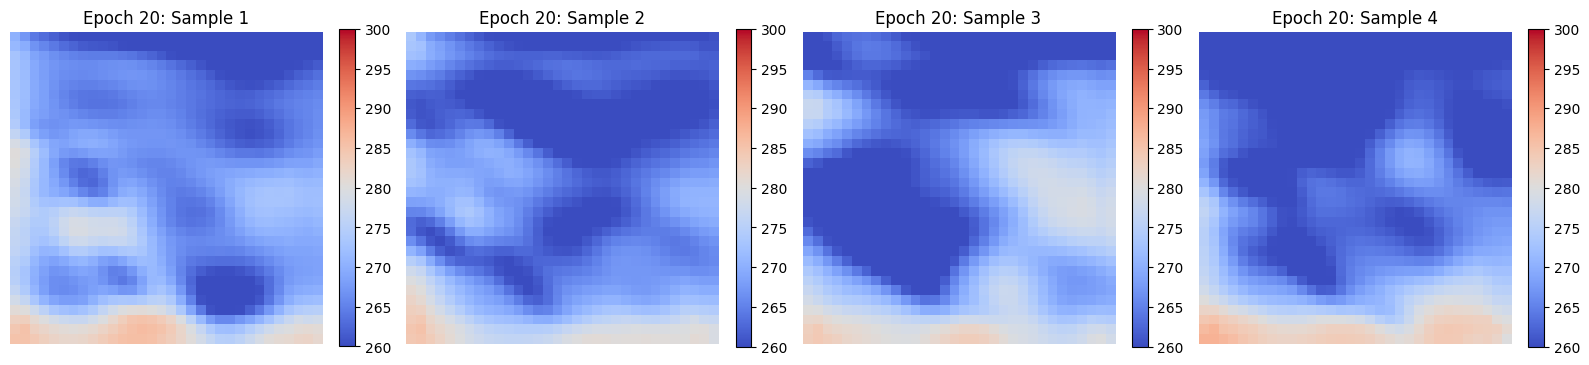

   ✓ Samples saved to checkpoints/samples/samples_epoch_020.png
--------------------------------------------------


Epoch 21/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 21/1000 [Train]:  13%|█▎        | 12/92 [00:06<00:21,  3.68it/s, loss=0.7898]

⚠️ Warning: NaN in model predictions at batch 12, skipping...


Epoch 21/1000 [Train]:  43%|████▎     | 40/92 [00:13<00:13,  3.94it/s, loss=0.7584]

⚠️ Warning: NaN in model predictions at batch 40, skipping...


Epoch 21/1000 [Train]:  55%|█████▌    | 51/92 [00:15<00:10,  3.98it/s, loss=0.6914]

⚠️ Warning: NaN in model predictions at batch 51, skipping...


Epoch 21/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 21/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.57it/s, loss=0.8107]



Epoch 21/1000:
  Train Loss: 0.761584
  Val Loss: 0.746458
  ✓ Saved best model (val_loss=0.746458)
--------------------------------------------------


Epoch 22/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 22/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 22/1


Epoch 22/1000:
  Train Loss: 0.741477
  Val Loss: 0.734642
  ✓ Saved best model (val_loss=0.734642)
--------------------------------------------------


Epoch 23/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 23/1000 [Train]:  27%|██▋       | 25/92 [00:09<00:16,  3.95it/s, loss=0.6588]

⚠️ Warning: NaN in model predictions at batch 25, skipping...


Epoch 23/1000 [Train]:  70%|██████▉   | 64/92 [00:19<00:07,  3.92it/s, loss=0.7314]

⚠️ Warning: NaN in model predictions at batch 64, skipping...


Epoch 23/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 23/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.57it/s, loss=0.5978]



Epoch 23/1000:
  Train Loss: 0.721195
  Val Loss: 0.712958
  ✓ Saved best model (val_loss=0.712958)
--------------------------------------------------


Epoch 24/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 24/1000 [Train]:  88%|████████▊ | 81/92 [00:23<00:02,  3.91it/s, loss=0.7254]

⚠️ Warning: NaN in model predictions at batch 81, skipping...


Epoch 24/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 24/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.57it/s, loss=0.7454]



Epoch 24/1000:
  Train Loss: 0.722756
  Val Loss: 0.718106
--------------------------------------------------


Epoch 25/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 25/1000 [Train]:   5%|▌         | 5/92 [00:04<00:47,  1.85it/s, loss=0.6374]

⚠️ Warning: NaN in model predictions at batch 5, skipping...


Epoch 25/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 25/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.6492]



Epoch 25/1000:
  Train Loss: 0.715382
  Val Loss: 0.692406
  ✓ Saved best model (val_loss=0.692406)

🎨 Generating samples at epoch 25...


/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


   📊 Sample stats: min=243.688812, max=292.751038, mean=266.419617, std=7.741240


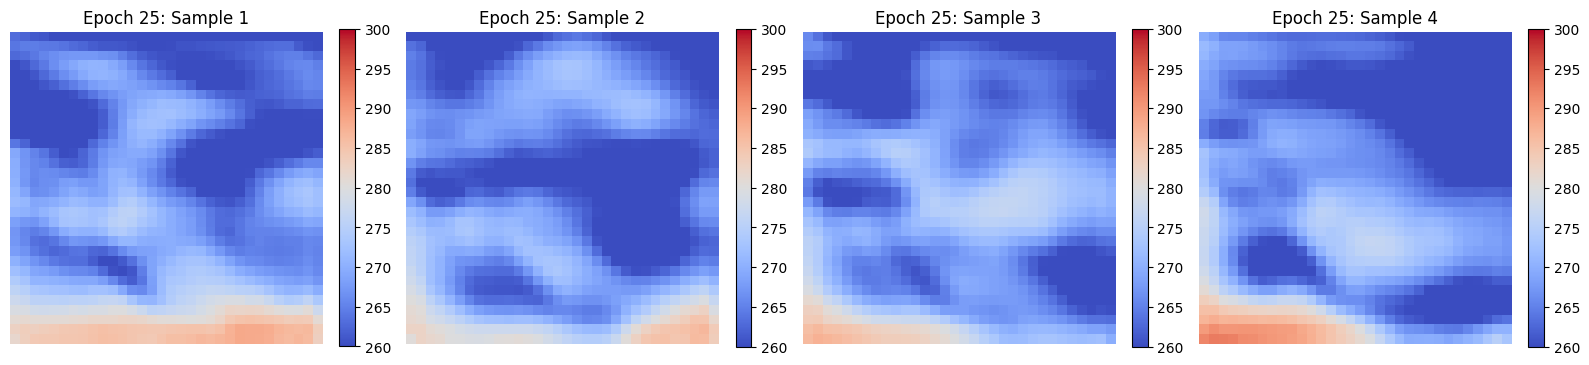

   ✓ Samples saved to checkpoints/samples/samples_epoch_025.png
--------------------------------------------------


Epoch 26/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 26/1000 [Train]:  62%|██████▏   | 57/92 [00:17<00:08,  3.92it/s, loss=0.7243]

⚠️ Warning: NaN in model predictions at batch 57, skipping...


Epoch 26/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 26/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.7197]



Epoch 26/1000:
  Train Loss: 0.697607
  Val Loss: 0.706284
--------------------------------------------------


Epoch 27/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 27/1000 [Train]:  54%|█████▍    | 50/92 [00:15<00:10,  3.95it/s, loss=0.6052]

⚠️ Warning: NaN in model predictions at batch 50, skipping...


Epoch 27/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 27/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.6998]



Epoch 27/1000:
  Train Loss: 0.693068
  Val Loss: 0.689293
  ✓ Saved best model (val_loss=0.689293)
--------------------------------------------------


Epoch 28/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 28/1000 [Train]:  14%|█▍        | 13/92 [00:07<00:21,  3.72it/s, loss=0.5668]

⚠️ Warning: NaN in model predictions at batch 13, skipping...


Epoch 28/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 28/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.57it/s, loss=0.6571]



Epoch 28/1000:
  Train Loss: 0.685966
  Val Loss: 0.684602
  ✓ Saved best model (val_loss=0.684602)
--------------------------------------------------


Epoch 29/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 29/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 29/1


Epoch 29/1000:
  Train Loss: 0.663695
  Val Loss: 0.648105
  ✓ Saved best model (val_loss=0.648105)
--------------------------------------------------


Epoch 30/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 30/1000 [Train]:  43%|████▎     | 40/92 [00:13<00:08,  6.04it/s, loss=0.6443]

⚠️ Warning: NaN in model predictions at batch 38, skipping...
⚠️ Warning: NaN in model predictions at batch 39, skipping...


Epoch 30/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 30/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.57it/s, loss=0.7110]



Epoch 30/1000:
  Train Loss: 0.653581
  Val Loss: 0.643105
  ✓ Saved best model (val_loss=0.643105)

🎨 Generating samples at epoch 30...


/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


   📊 Sample stats: min=246.005203, max=289.700317, mean=267.648529, std=7.668058


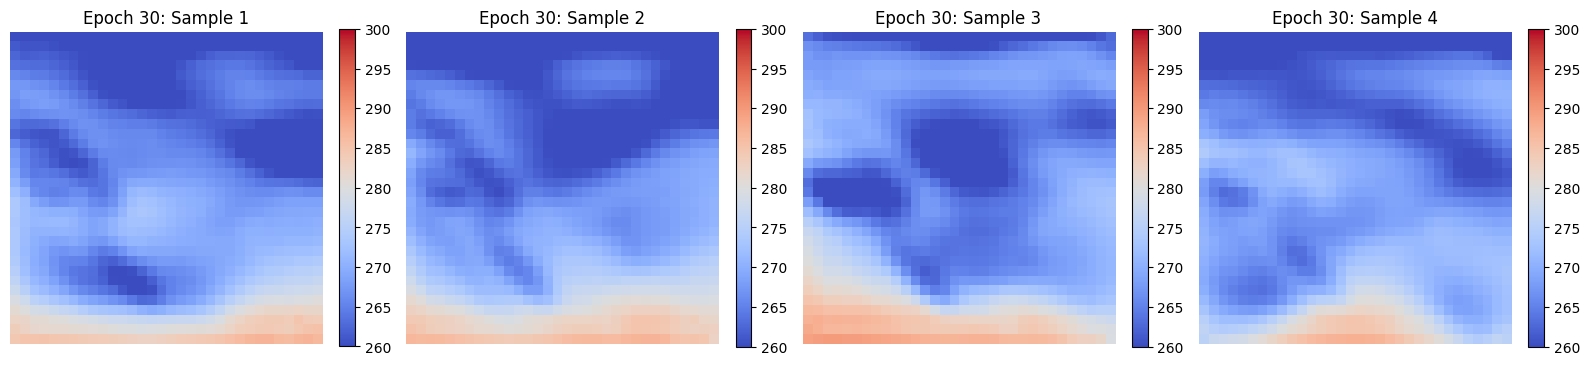

   ✓ Samples saved to checkpoints/samples/samples_epoch_030.png
--------------------------------------------------


Epoch 31/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 31/1000 [Train]:   5%|▌         | 5/92 [00:04<00:46,  1.87it/s, loss=0.6119]

⚠️ Warning: NaN in model predictions at batch 5, skipping...


Epoch 31/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 31/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.57it/s, loss=0.6227]



Epoch 31/1000:
  Train Loss: 0.657644
  Val Loss: 0.653658
--------------------------------------------------


Epoch 32/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 32/1000 [Train]:  11%|█         | 10/92 [00:05<00:24,  3.39it/s, loss=0.7345]

⚠️ Warning: NaN in model predictions at batch 10, skipping...


Epoch 32/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 32/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.5657]



Epoch 32/1000:
  Train Loss: 0.635701
  Val Loss: 0.636947
  ✓ Saved best model (val_loss=0.636947)
--------------------------------------------------


Epoch 33/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 33/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 33/1


Epoch 33/1000:
  Train Loss: 0.637719
  Val Loss: 0.630317
  ✓ Saved best model (val_loss=0.630317)
--------------------------------------------------


Epoch 34/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 34/1000 [Train]:  92%|█████████▏| 85/92 [00:25<00:01,  3.92it/s, loss=0.5961]

⚠️ Warning: NaN in model predictions at batch 85, skipping...


Epoch 34/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 34/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.54it/s, loss=0.7034]



Epoch 34/1000:
  Train Loss: 0.616426
  Val Loss: 0.641254
--------------------------------------------------


Epoch 35/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 35/1000 [Train]:  30%|███       | 28/92 [00:10<00:16,  3.94it/s, loss=0.5000]

⚠️ Warning: NaN in model predictions at batch 28, skipping...


Epoch 35/1000 [Train]:  54%|█████▍    | 50/92 [00:15<00:10,  3.93it/s, loss=0.4899]

⚠️ Warning: NaN in model predictions at batch 50, skipping...


Epoch 35/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 35/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, loss=0.6691]


Epoch 35/1000:
  Train Loss: 0.624473
  Val Loss: 0.639751

🎨 Generating samples at epoch 35...



/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


   📊 Sample stats: min=243.939590, max=289.383789, mean=265.656738, std=9.246502


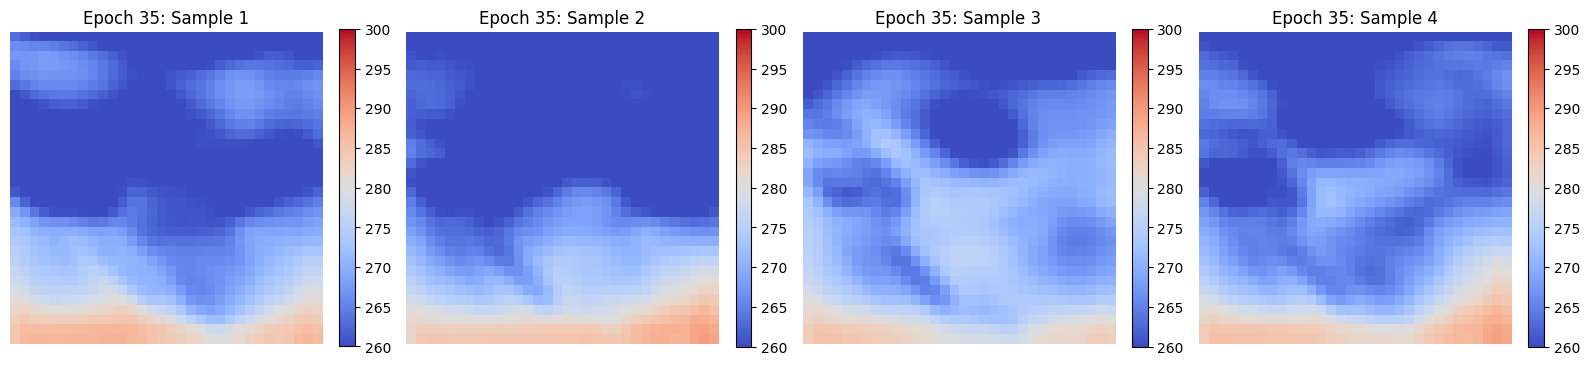

   ✓ Samples saved to checkpoints/samples/samples_epoch_035.png
--------------------------------------------------


Epoch 36/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 36/1000 [Train]:  28%|██▊       | 26/92 [00:09<00:16,  3.94it/s, loss=0.6377]

⚠️ Warning: NaN in model predictions at batch 26, skipping...


Epoch 36/1000 [Train]:  75%|███████▌  | 69/92 [00:20<00:05,  3.93it/s, loss=0.5538]

⚠️ Warning: NaN in model predictions at batch 69, skipping...


Epoch 36/1000 [Train]:  90%|█████████ | 83/92 [00:23<00:02,  3.95it/s, loss=0.6152]

⚠️ Warning: NaN in model predictions at batch 83, skipping...


Epoch 36/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 36/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.54it/s, loss=0.6222]



Epoch 36/1000:
  Train Loss: 0.618828
  Val Loss: 0.617166
  ✓ Saved best model (val_loss=0.617166)
--------------------------------------------------


Epoch 37/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 37/1000 [Train]:  28%|██▊       | 26/92 [00:10<00:16,  3.94it/s, loss=0.6139]

⚠️ Warning: NaN in model predictions at batch 26, skipping...


Epoch 37/1000 [Train]:  74%|███████▍  | 68/92 [00:20<00:03,  6.05it/s, loss=0.6182]

⚠️ Warning: NaN in model predictions at batch 66, skipping...
⚠️ Warning: NaN in model predictions at batch 67, skipping...


Epoch 37/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 37/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, loss=0.6626]



Epoch 37/1000:
  Train Loss: 0.608588
  Val Loss: 0.581891
  ✓ Saved best model (val_loss=0.581891)
--------------------------------------------------


Epoch 38/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 38/1000 [Train]:  49%|████▉     | 45/92 [00:14<00:11,  3.94it/s, loss=0.5962]

⚠️ Warning: NaN in model predictions at batch 45, skipping...


Epoch 38/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 38/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, loss=0.5944]



Epoch 38/1000:
  Train Loss: 0.605768
  Val Loss: 0.568861
  ✓ Saved best model (val_loss=0.568861)
--------------------------------------------------


Epoch 39/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 39/1000 [Train]:  13%|█▎        | 12/92 [00:06<00:21,  3.67it/s, loss=0.6391]

⚠️ Warning: NaN in model predictions at batch 12, skipping...


Epoch 39/1000 [Train]:  18%|█▊        | 17/92 [00:07<00:18,  4.14it/s, loss=0.5534]

⚠️ Warning: NaN in model predictions at batch 17, skipping...


Epoch 39/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 39/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.55it/s, loss=0.6675]



Epoch 39/1000:
  Train Loss: 0.586393
  Val Loss: 0.568160
  ✓ Saved best model (val_loss=0.568160)
--------------------------------------------------


Epoch 40/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 40/1000 [Train]:  17%|█▋        | 16/92 [00:07<00:19,  3.86it/s, loss=0.6160]

⚠️ Warning: NaN in model predictions at batch 16, skipping...


Epoch 40/1000 [Train]:  39%|███▉      | 36/92 [00:12<00:14,  3.96it/s, loss=0.6103]

⚠️ Warning: NaN in model predictions at batch 36, skipping...


Epoch 40/1000 [Train]:  54%|█████▍    | 50/92 [00:15<00:10,  3.91it/s, loss=0.5962]

⚠️ Warning: NaN in model predictions at batch 50, skipping...


Epoch 40/1000 [Train]:  89%|████████▉ | 82/92 [00:23<00:02,  3.93it/s, loss=0.6748]

⚠️ Warning: NaN in model predictions at batch 82, skipping...


Epoch 40/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 40/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.55it/s, loss=0.6884]


Epoch 40/1000:
  Train Loss: 0.574755
  Val Loss: 0.579186

🎨 Generating samples at epoch 40...



/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


   📊 Sample stats: min=249.755814, max=290.973541, mean=268.563843, std=8.413075


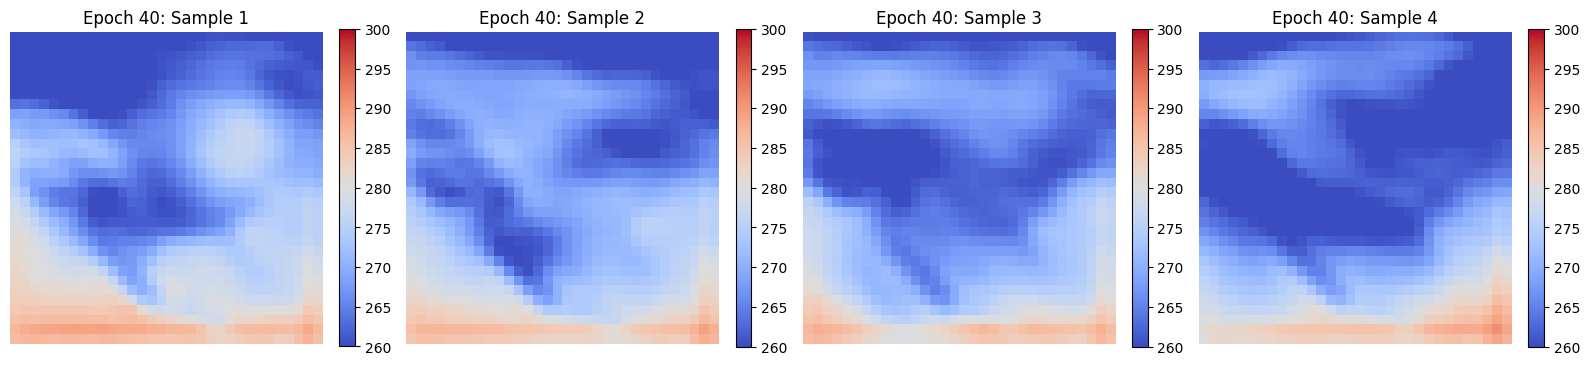

   ✓ Samples saved to checkpoints/samples/samples_epoch_040.png
--------------------------------------------------


Epoch 41/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 41/1000 [Train]:   7%|▋         | 6/92 [00:04<00:38,  2.22it/s, loss=0.5941]

⚠️ Warning: NaN in model predictions at batch 6, skipping...


Epoch 41/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 41/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.55it/s, loss=0.6491]



Epoch 41/1000:
  Train Loss: 0.560752
  Val Loss: 0.576580
--------------------------------------------------


Epoch 42/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 42/1000 [Train]:  33%|███▎      | 30/92 [00:10<00:15,  3.93it/s, loss=0.5134]

⚠️ Warning: NaN in model predictions at batch 30, skipping...


Epoch 42/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 42/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.54it/s, loss=0.5494]



Epoch 42/1000:
  Train Loss: 0.567341
  Val Loss: 0.560561
  ✓ Saved best model (val_loss=0.560561)
--------------------------------------------------


Epoch 43/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 43/1000 [Train]:  83%|████████▎ | 76/92 [00:23<00:04,  3.94it/s, loss=0.5953]

⚠️ Warning: NaN in model predictions at batch 76, skipping...


Epoch 43/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 43/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.53it/s, loss=0.4571]



Epoch 43/1000:
  Train Loss: 0.553428
  Val Loss: 0.548116
  ✓ Saved best model (val_loss=0.548116)
--------------------------------------------------


Epoch 44/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 44/1000 [Train]:  16%|█▋        | 15/92 [00:07<00:20,  3.82it/s, loss=0.6243]

⚠️ Warning: NaN in model predictions at batch 15, skipping...


Epoch 44/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 44/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.53it/s, loss=0.4967]



Epoch 44/1000:
  Train Loss: 0.547246
  Val Loss: 0.557425
--------------------------------------------------


Epoch 45/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 45/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 45/1


Epoch 45/1000:
  Train Loss: 0.533767
  Val Loss: 0.503674
  ✓ Saved best model (val_loss=0.503674)

🎨 Generating samples at epoch 45...


/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


   📊 Sample stats: min=245.990784, max=292.530457, mean=269.357605, std=9.660112


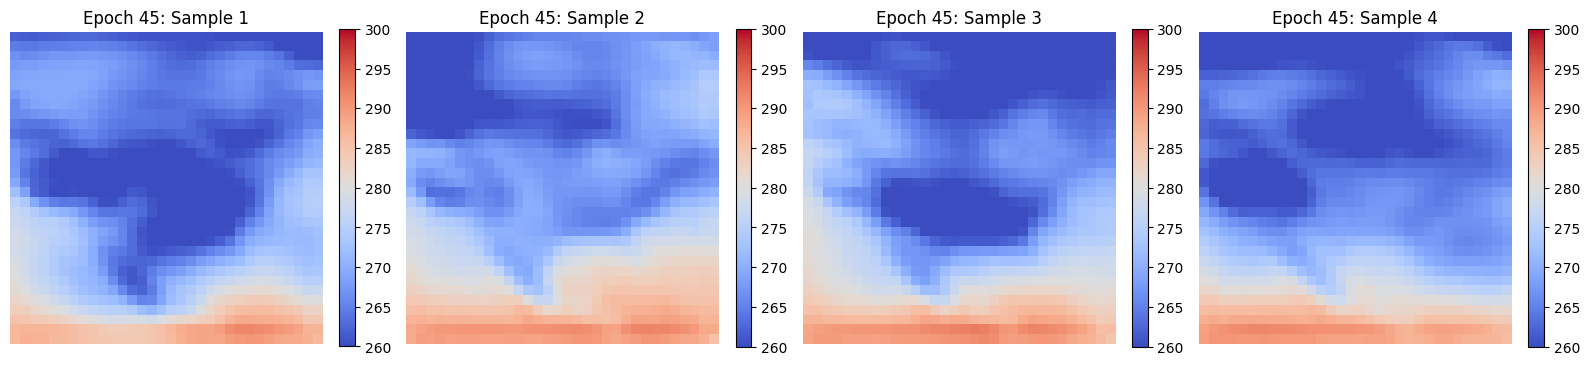

   ✓ Samples saved to checkpoints/samples/samples_epoch_045.png
--------------------------------------------------


Epoch 46/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 46/1000 [Train]:   3%|▎         | 3/92 [00:04<01:30,  1.02s/it, loss=0.5283]

⚠️ Warning: NaN in model predictions at batch 3, skipping...


Epoch 46/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 46/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.57it/s, loss=0.5835]



Epoch 46/1000:
  Train Loss: 0.522413
  Val Loss: 0.526084
--------------------------------------------------


Epoch 47/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 47/1000 [Train]:  11%|█         | 10/92 [00:05<00:24,  3.39it/s, loss=0.5672]

⚠️ Warning: NaN in model predictions at batch 10, skipping...


Epoch 47/1000 [Train]:  51%|█████     | 47/92 [00:15<00:11,  3.93it/s, loss=0.5421]

⚠️ Warning: NaN in model predictions at batch 47, skipping...


Epoch 47/1000 [Train]:  73%|███████▎  | 67/92 [00:19<00:06,  3.92it/s, loss=0.4914]

⚠️ Warning: NaN in model predictions at batch 67, skipping...


Epoch 47/1000 [Train]:  77%|███████▋  | 71/92 [00:20<00:04,  4.31it/s, loss=0.5097]

⚠️ Warning: NaN in model predictions at batch 71, skipping...


Epoch 47/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 47/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, loss=0.4231]



Epoch 47/1000:
  Train Loss: 0.524342
  Val Loss: 0.519784
--------------------------------------------------


Epoch 48/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 48/1000 [Train]:  12%|█▏        | 11/92 [00:06<00:23,  3.49it/s, loss=0.3938]

⚠️ Warning: NaN in model predictions at batch 11, skipping...


Epoch 48/1000 [Train]:  37%|███▋      | 34/92 [00:11<00:14,  3.96it/s, loss=0.5815]

⚠️ Warning: NaN in model predictions at batch 34, skipping...


Epoch 48/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 48/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.54it/s, loss=0.5805]



Epoch 48/1000:
  Train Loss: 0.510152
  Val Loss: 0.502218
  ✓ Saved best model (val_loss=0.502218)
--------------------------------------------------


Epoch 49/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 49/1000 [Train]:  55%|█████▌    | 51/92 [00:16<00:10,  3.92it/s, loss=0.5565]

⚠️ Warning: NaN in model predictions at batch 51, skipping...


Epoch 49/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 49/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.53it/s, loss=0.5109]



Epoch 49/1000:
  Train Loss: 0.499497
  Val Loss: 0.503458
--------------------------------------------------


Epoch 50/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 50/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 50/1


Epoch 50/1000:
  Train Loss: 0.496640
  Val Loss: 0.502610

🎨 Generating samples at epoch 50...



/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


   📊 Sample stats: min=240.838974, max=287.277344, mean=265.928284, std=8.992661


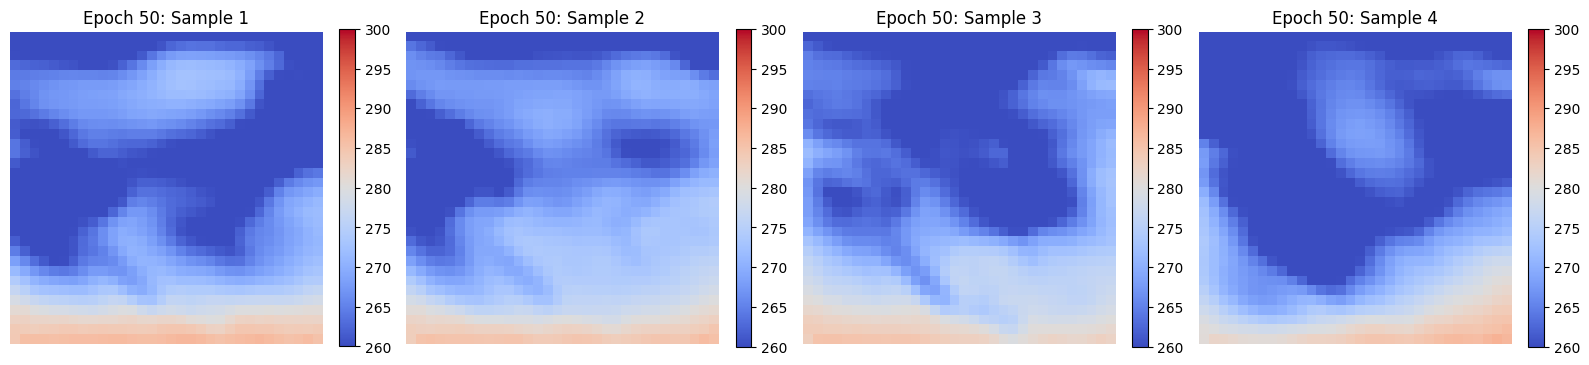

   ✓ Samples saved to checkpoints/samples/samples_epoch_050.png
--------------------------------------------------


Epoch 51/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 51/1000 [Train]:  23%|██▎       | 21/92 [00:08<00:18,  3.94it/s, loss=0.4926]

⚠️ Warning: NaN in model predictions at batch 21, skipping...


Epoch 51/1000 [Train]:  35%|███▍      | 32/92 [00:11<00:15,  3.98it/s, loss=0.4269]

⚠️ Warning: NaN in model predictions at batch 32, skipping...


Epoch 51/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 51/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, loss=0.3150]



Epoch 51/1000:
  Train Loss: 0.498228
  Val Loss: 0.475788
  ✓ Saved best model (val_loss=0.475788)
--------------------------------------------------


Epoch 52/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 52/1000 [Train]:  25%|██▌       | 23/92 [00:09<00:17,  3.94it/s, loss=0.5835]

⚠️ Warning: NaN in model predictions at batch 23, skipping...


Epoch 52/1000 [Train]:  83%|████████▎ | 76/92 [00:22<00:04,  3.92it/s, loss=0.5591]

⚠️ Warning: NaN in model predictions at batch 76, skipping...


Epoch 52/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 52/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.4140]



Epoch 52/1000:
  Train Loss: 0.473870
  Val Loss: 0.472454
  ✓ Saved best model (val_loss=0.472454)
--------------------------------------------------


Epoch 53/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 53/1000 [Train]:  88%|████████▊ | 81/92 [00:24<00:02,  3.91it/s, loss=0.4901]

⚠️ Warning: NaN in model predictions at batch 81, skipping...


Epoch 53/1000 [Train]:  90%|█████████ | 83/92 [00:24<00:01,  4.72it/s, loss=0.4993]

⚠️ Warning: NaN in model predictions at batch 83, skipping...


Epoch 53/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 53/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.4737]



Epoch 53/1000:
  Train Loss: 0.479417
  Val Loss: 0.471739
  ✓ Saved best model (val_loss=0.471739)
--------------------------------------------------


Epoch 54/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 54/1000 [Train]:  27%|██▋       | 25/92 [00:09<00:16,  3.95it/s, loss=0.4382]

⚠️ Warning: NaN in model predictions at batch 25, skipping...


Epoch 54/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 54/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, loss=0.5577]



Epoch 54/1000:
  Train Loss: 0.467966
  Val Loss: 0.459860
  ✓ Saved best model (val_loss=0.459860)
--------------------------------------------------


Epoch 55/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 55/1000 [Train]:  51%|█████     | 47/92 [00:15<00:11,  3.93it/s, loss=0.4777]

⚠️ Warning: NaN in model predictions at batch 47, skipping...


Epoch 55/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 55/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.54it/s, loss=0.4392]


Epoch 55/1000:
  Train Loss: 0.460076
  Val Loss: 0.460065

🎨 Generating samples at epoch 55...



/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


   📊 Sample stats: min=238.425583, max=289.453247, mean=266.198975, std=9.705523


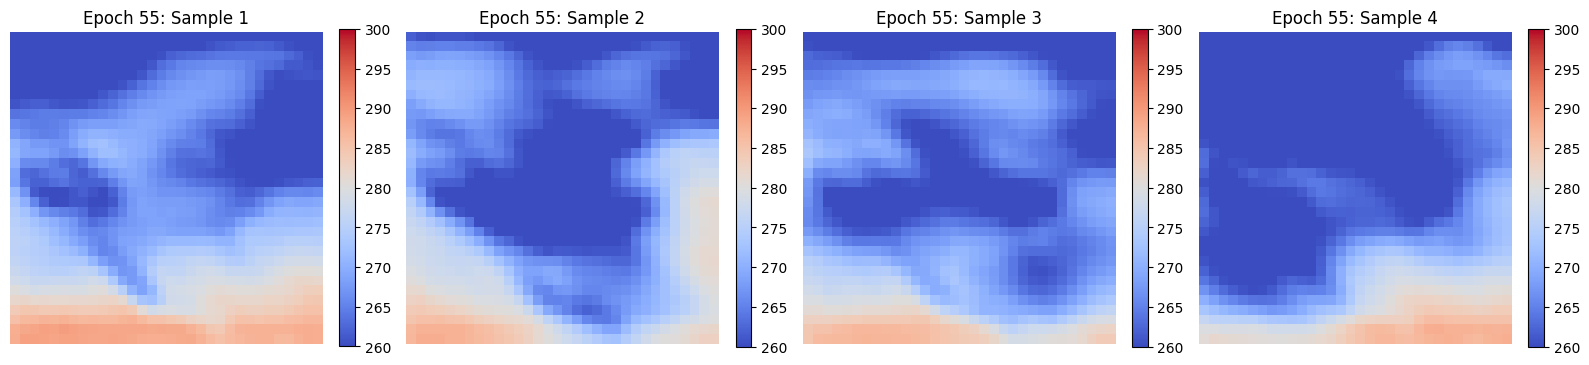

   ✓ Samples saved to checkpoints/samples/samples_epoch_055.png
--------------------------------------------------


Epoch 56/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 56/1000 [Train]:  33%|███▎      | 30/92 [00:11<00:15,  3.94it/s, loss=0.3732]

⚠️ Warning: NaN in model predictions at batch 30, skipping...


Epoch 56/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 56/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.55it/s, loss=0.4231]



Epoch 56/1000:
  Train Loss: 0.458218
  Val Loss: 0.449739
  ✓ Saved best model (val_loss=0.449739)
--------------------------------------------------


Epoch 57/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 57/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 57/1


Epoch 57/1000:
  Train Loss: 0.452567
  Val Loss: 0.439125
  ✓ Saved best model (val_loss=0.439125)
--------------------------------------------------


Epoch 58/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 58/1000 [Train]:  33%|███▎      | 30/92 [00:11<00:15,  3.93it/s, loss=0.4256]

⚠️ Warning: NaN in model predictions at batch 30, skipping...


Epoch 58/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 58/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, loss=0.5070]



Epoch 58/1000:
  Train Loss: 0.429758
  Val Loss: 0.444791
--------------------------------------------------


Epoch 59/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 59/1000 [Train]:  41%|████▏     | 38/92 [00:13<00:13,  3.93it/s, loss=0.3429]

⚠️ Warning: NaN in model predictions at batch 38, skipping...


Epoch 59/1000 [Train]:  60%|█████▉    | 55/92 [00:17<00:09,  3.94it/s, loss=0.4424]

⚠️ Warning: NaN in model predictions at batch 55, skipping...


Epoch 59/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 59/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.54it/s, loss=0.4548]



Epoch 59/1000:
  Train Loss: 0.445744
  Val Loss: 0.410690
  ✓ Saved best model (val_loss=0.410690)
--------------------------------------------------


Epoch 60/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 60/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 60/1


Epoch 60/1000:
  Train Loss: 0.410545
  Val Loss: 0.417944

🎨 Generating samples at epoch 60...



/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


   📊 Sample stats: min=240.250641, max=289.656128, mean=266.626648, std=9.635114


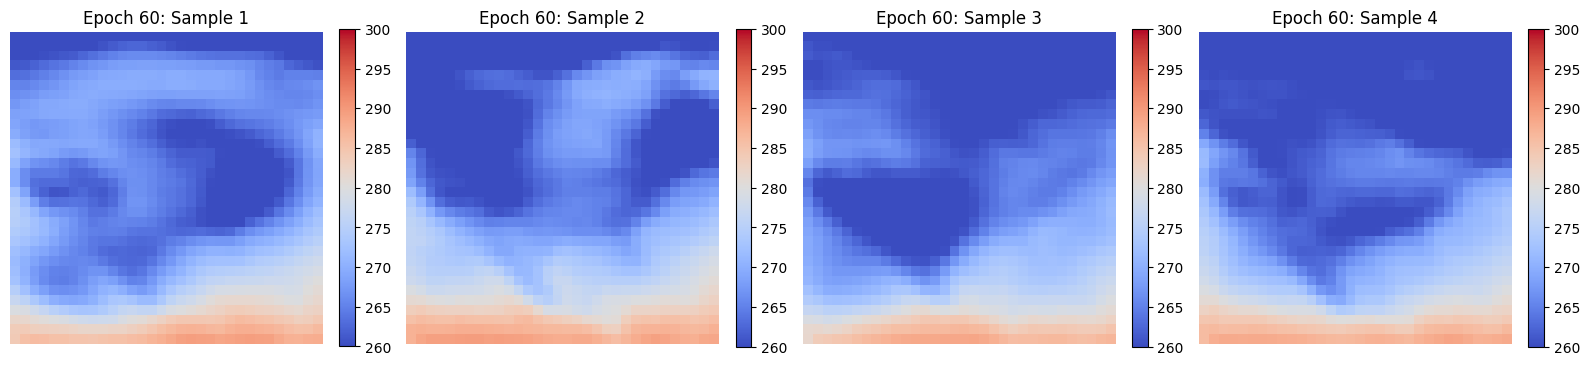

   ✓ Samples saved to checkpoints/samples/samples_epoch_060.png
--------------------------------------------------


Epoch 61/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 61/1000 [Train]:  34%|███▎      | 31/92 [00:11<00:15,  3.95it/s, loss=0.4255]

⚠️ Warning: NaN in model predictions at batch 31, skipping...


Epoch 61/1000 [Train]:  74%|███████▍  | 68/92 [00:20<00:06,  3.94it/s, loss=0.3867]

⚠️ Warning: NaN in model predictions at batch 68, skipping...


Epoch 61/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 61/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.53it/s, loss=0.3481]



Epoch 61/1000:
  Train Loss: 0.428594
  Val Loss: 0.400909
  ✓ Saved best model (val_loss=0.400909)
--------------------------------------------------


Epoch 62/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 62/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 62/1


Epoch 62/1000:
  Train Loss: 0.404591
  Val Loss: 0.411490
--------------------------------------------------


Epoch 63/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 63/1000 [Train]:  12%|█▏        | 11/92 [00:06<00:22,  3.55it/s, loss=0.5278]

⚠️ Warning: NaN in model predictions at batch 11, skipping...


Epoch 63/1000 [Train]:  58%|█████▊    | 53/92 [00:16<00:09,  3.95it/s, loss=0.5096]

⚠️ Warning: NaN in model predictions at batch 53, skipping...


Epoch 63/1000 [Train]:  75%|███████▌  | 69/92 [00:20<00:05,  3.91it/s, loss=0.4793]

⚠️ Warning: NaN in model predictions at batch 69, skipping...


Epoch 63/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 63/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.4512]



Epoch 63/1000:
  Train Loss: 0.412083
  Val Loss: 0.408352
--------------------------------------------------


Epoch 64/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 64/1000 [Train]:  39%|███▉      | 36/92 [00:12<00:14,  3.93it/s, loss=0.3251]

⚠️ Warning: NaN in model predictions at batch 36, skipping...


Epoch 64/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 64/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, loss=0.4185]



Epoch 64/1000:
  Train Loss: 0.401630
  Val Loss: 0.411663
--------------------------------------------------


Epoch 65/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 65/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 65/1


Epoch 65/1000:
  Train Loss: 0.387967
  Val Loss: 0.395560
  ✓ Saved best model (val_loss=0.395560)

🎨 Generating samples at epoch 65...


/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


   📊 Sample stats: min=242.045776, max=289.783325, mean=269.220520, std=9.039717


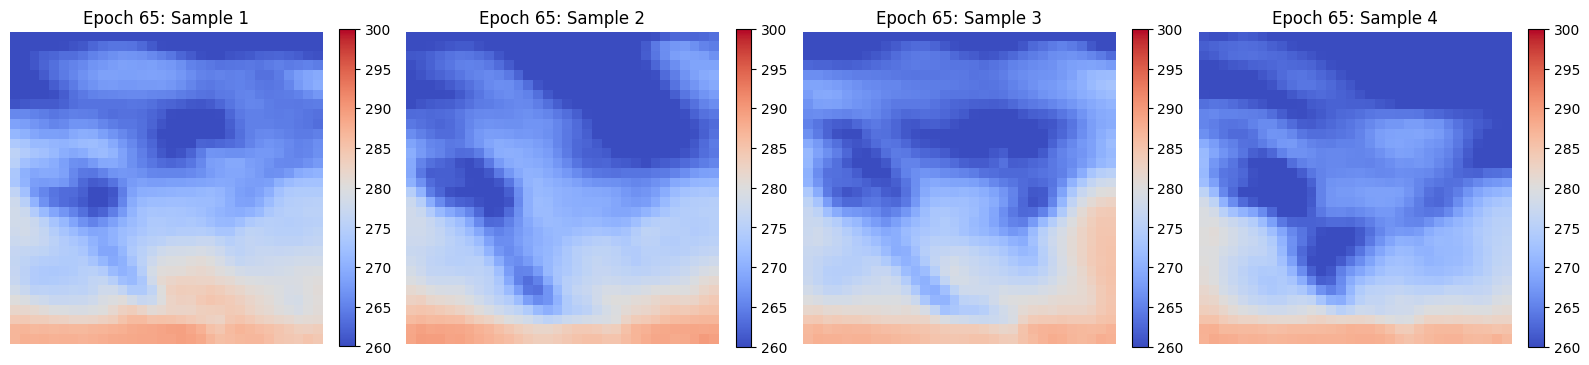

   ✓ Samples saved to checkpoints/samples/samples_epoch_065.png
--------------------------------------------------


Epoch 66/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 66/1000 [Train]:   1%|          | 1/92 [00:03<05:05,  3.36s/it]

⚠️ Warning: NaN in model predictions at batch 0, skipping...


Epoch 66/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 66/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, loss=0.3512]



Epoch 66/1000:
  Train Loss: 0.380949
  Val Loss: 0.388844
  ✓ Saved best model (val_loss=0.388844)
--------------------------------------------------


Epoch 67/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 67/1000 [Train]:  27%|██▋       | 25/92 [00:09<00:17,  3.93it/s, loss=0.5229]

⚠️ Warning: NaN in model predictions at batch 25, skipping...


Epoch 67/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 67/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, loss=0.2961]



Epoch 67/1000:
  Train Loss: 0.396011
  Val Loss: 0.373497
  ✓ Saved best model (val_loss=0.373497)
--------------------------------------------------


Epoch 68/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 68/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 68/1


Epoch 68/1000:
  Train Loss: 0.380395
  Val Loss: 0.376036
--------------------------------------------------


Epoch 69/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 69/1000 [Train]:  55%|█████▌    | 51/92 [00:16<00:10,  3.94it/s, loss=0.2806]

⚠️ Warning: NaN in model predictions at batch 51, skipping...


Epoch 69/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 69/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.55it/s, loss=0.3274]



Epoch 69/1000:
  Train Loss: 0.390310
  Val Loss: 0.365251
  ✓ Saved best model (val_loss=0.365251)
--------------------------------------------------


Epoch 70/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 70/1000 [Train]:  23%|██▎       | 21/92 [00:08<00:18,  3.92it/s, loss=0.4572]

⚠️ Warning: NaN in model predictions at batch 21, skipping...


Epoch 70/1000 [Train]:  63%|██████▎   | 58/92 [00:18<00:08,  3.92it/s, loss=0.3019]

⚠️ Warning: NaN in model predictions at batch 58, skipping...


Epoch 70/1000 [Train]:  77%|███████▋  | 71/92 [00:21<00:05,  3.91it/s, loss=0.3047]

⚠️ Warning: NaN in model predictions at batch 71, skipping...


Epoch 70/1000 [Train]:  93%|█████████▎| 86/92 [00:24<00:01,  3.92it/s, loss=0.3824]

⚠️ Warning: NaN in model predictions at batch 86, skipping...


Epoch 70/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 70/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.3581]


Epoch 70/1000:
  Train Loss: 0.366473
  Val Loss: 0.369778

🎨 Generating samples at epoch 70...



/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


   📊 Sample stats: min=238.207626, max=291.145325, mean=266.702515, std=10.874225


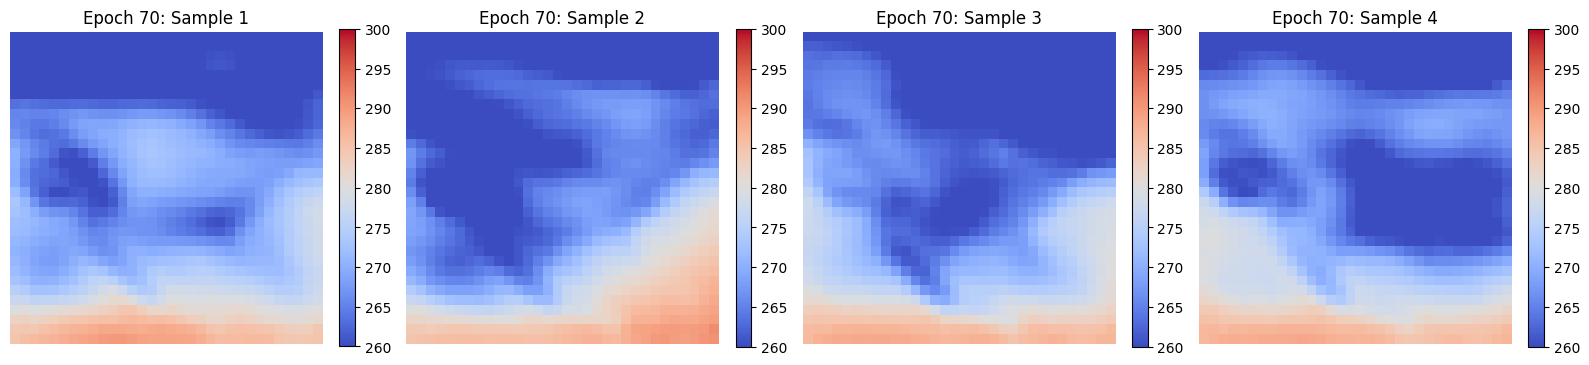

   ✓ Samples saved to checkpoints/samples/samples_epoch_070.png
--------------------------------------------------


Epoch 71/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 71/1000 [Train]:  33%|███▎      | 30/92 [00:10<00:15,  3.95it/s, loss=0.4120]

⚠️ Warning: NaN in model predictions at batch 30, skipping...


Epoch 71/1000 [Train]:  77%|███████▋  | 71/92 [00:21<00:05,  3.92it/s, loss=0.2872]

⚠️ Warning: NaN in model predictions at batch 71, skipping...


Epoch 71/1000 [Train]:  96%|█████████▌| 88/92 [00:25<00:01,  3.94it/s, loss=0.4507]

⚠️ Warning: NaN in model predictions at batch 88, skipping...


Epoch 71/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 71/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.4664]



Epoch 71/1000:
  Train Loss: 0.365959
  Val Loss: 0.363228
  ✓ Saved best model (val_loss=0.363228)
--------------------------------------------------


Epoch 72/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 72/1000 [Train]:   1%|          | 1/92 [00:03<05:16,  3.47s/it]

⚠️ Warning: NaN in model predictions at batch 0, skipping...


Epoch 72/1000 [Train]:  24%|██▍       | 22/92 [00:08<00:17,  3.95it/s, loss=0.3307]

⚠️ Warning: NaN in model predictions at batch 22, skipping...


Epoch 72/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 72/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.3711]



Epoch 72/1000:
  Train Loss: 0.354408
  Val Loss: 0.344098
  ✓ Saved best model (val_loss=0.344098)
--------------------------------------------------


Epoch 73/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 73/1000 [Train]:  22%|██▏       | 20/92 [00:08<00:18,  3.93it/s, loss=0.3093]

⚠️ Warning: NaN in model predictions at batch 20, skipping...


Epoch 73/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 73/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.4935]



Epoch 73/1000:
  Train Loss: 0.343647
  Val Loss: 0.360180
--------------------------------------------------


Epoch 74/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 74/1000 [Train]:  11%|█         | 10/92 [00:05<00:24,  3.40it/s, loss=0.3426]

⚠️ Warning: NaN in model predictions at batch 10, skipping...


Epoch 74/1000 [Train]:  21%|██        | 19/92 [00:07<00:18,  3.97it/s, loss=0.3018]

⚠️ Warning: NaN in model predictions at batch 19, skipping...


Epoch 74/1000 [Train]:  36%|███▌      | 33/92 [00:11<00:14,  3.96it/s, loss=0.3659]

⚠️ Warning: NaN in model predictions at batch 33, skipping...


Epoch 74/1000 [Train]:  55%|█████▌    | 51/92 [00:15<00:10,  3.93it/s, loss=0.3612]

⚠️ Warning: NaN in model predictions at batch 51, skipping...


Epoch 74/1000 [Train]:  84%|████████▎ | 77/92 [00:22<00:03,  3.94it/s, loss=0.4096]

⚠️ Warning: NaN in model predictions at batch 77, skipping...


Epoch 74/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 74/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.54it/s, loss=0.2856]



Epoch 74/1000:
  Train Loss: 0.344383
  Val Loss: 0.359233
--------------------------------------------------


Epoch 75/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 75/1000 [Train]:  40%|████      | 37/92 [00:12<00:13,  3.94it/s, loss=0.2620]

⚠️ Warning: NaN in model predictions at batch 37, skipping...


Epoch 75/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 75/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.54it/s, loss=0.3129]



Epoch 75/1000:
  Train Loss: 0.339667
  Val Loss: 0.339096
  ✓ Saved best model (val_loss=0.339096)

🎨 Generating samples at epoch 75...


/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


   📊 Sample stats: min=245.475479, max=299.282837, mean=268.841522, std=10.213641


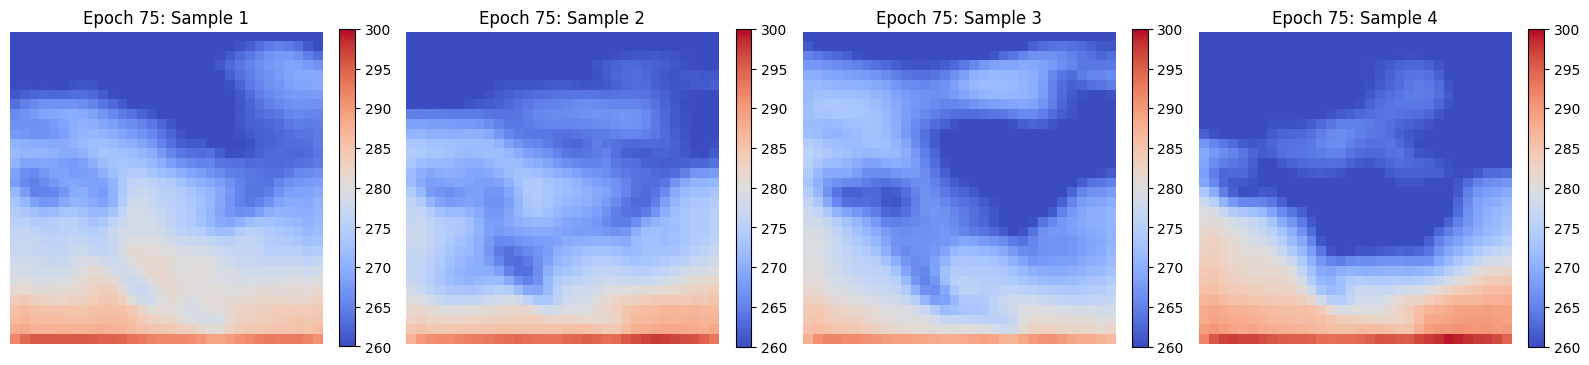

   ✓ Samples saved to checkpoints/samples/samples_epoch_075.png
--------------------------------------------------


Epoch 76/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 76/1000 [Train]:   5%|▌         | 5/92 [00:04<00:47,  1.83it/s, loss=0.3792]

⚠️ Warning: NaN in model predictions at batch 5, skipping...


Epoch 76/1000 [Train]:  48%|████▊     | 44/92 [00:14<00:12,  3.91it/s, loss=0.3750]

⚠️ Warning: NaN in model predictions at batch 44, skipping...


Epoch 76/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 76/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.55it/s, loss=0.3167]



Epoch 76/1000:
  Train Loss: 0.335204
  Val Loss: 0.347588
--------------------------------------------------


Epoch 77/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 77/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 77/1


Epoch 77/1000:
  Train Loss: 0.332343
  Val Loss: 0.346509
--------------------------------------------------


Epoch 78/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 78/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 78/1


Epoch 78/1000:
  Train Loss: 0.327270
  Val Loss: 0.305748
  ✓ Saved best model (val_loss=0.305748)
--------------------------------------------------


Epoch 79/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 79/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 79/1


Epoch 79/1000:
  Train Loss: 0.315676
  Val Loss: 0.311638
--------------------------------------------------


Epoch 80/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 80/1000 [Train]:  18%|█▊        | 17/92 [00:07<00:19,  3.87it/s, loss=0.2731]

⚠️ Warning: NaN in model predictions at batch 17, skipping...


Epoch 80/1000 [Train]:  26%|██▌       | 24/92 [00:09<00:17,  3.95it/s, loss=0.3826]

⚠️ Warning: NaN in model predictions at batch 24, skipping...


Epoch 80/1000 [Train]:  88%|████████▊ | 81/92 [00:23<00:02,  3.92it/s, loss=0.3494]

⚠️ Warning: NaN in model predictions at batch 81, skipping...


Epoch 80/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 80/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, loss=0.3357]


Epoch 80/1000:
  Train Loss: 0.312403
  Val Loss: 0.321188

🎨 Generating samples at epoch 80...



/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


   📊 Sample stats: min=242.318253, max=293.873901, mean=268.166046, std=11.815751


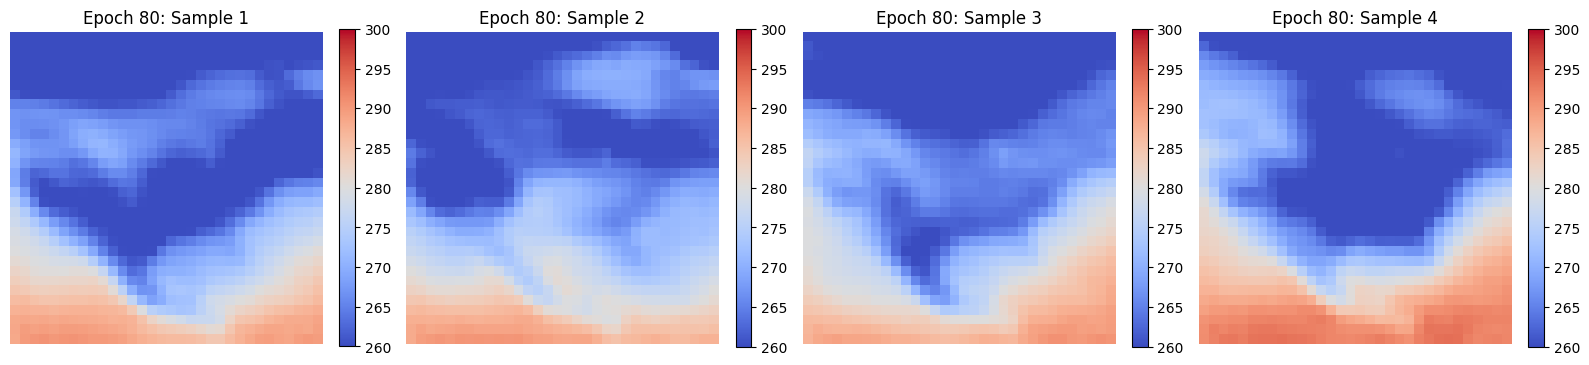

   ✓ Samples saved to checkpoints/samples/samples_epoch_080.png
--------------------------------------------------


Epoch 81/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 81/1000 [Train]:  55%|█████▌    | 51/92 [00:16<00:10,  3.93it/s, loss=0.3215]

⚠️ Warning: NaN in model predictions at batch 51, skipping...


Epoch 81/1000 [Train]:  75%|███████▌  | 69/92 [00:20<00:05,  3.94it/s, loss=0.2520]

⚠️ Warning: NaN in model predictions at batch 69, skipping...


Epoch 81/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 81/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.53it/s, loss=0.2559]



Epoch 81/1000:
  Train Loss: 0.308291
  Val Loss: 0.314756
--------------------------------------------------


Epoch 82/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 82/1000 [Train]:  82%|████████▏ | 75/92 [00:22<00:04,  3.94it/s, loss=0.3868]

⚠️ Warning: NaN in model predictions at batch 75, skipping...


Epoch 82/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 82/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.54it/s, loss=0.2847]



Epoch 82/1000:
  Train Loss: 0.308805
  Val Loss: 0.304305
  ✓ Saved best model (val_loss=0.304305)
--------------------------------------------------


Epoch 83/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 83/1000 [Train]:  35%|███▍      | 32/92 [00:11<00:15,  3.96it/s, loss=0.2608]

⚠️ Warning: NaN in model predictions at batch 32, skipping...


Epoch 83/1000 [Train]:  52%|█████▏    | 48/92 [00:15<00:11,  3.92it/s, loss=0.2522]

⚠️ Warning: NaN in model predictions at batch 48, skipping...


Epoch 83/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 83/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.50it/s, loss=0.3807]



Epoch 83/1000:
  Train Loss: 0.293256
  Val Loss: 0.289447
  ✓ Saved best model (val_loss=0.289447)
--------------------------------------------------


Epoch 84/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 84/1000 [Train]:  85%|████████▍ | 78/92 [00:23<00:03,  3.92it/s, loss=0.2592]

⚠️ Warning: NaN in model predictions at batch 78, skipping...


Epoch 84/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 84/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.51it/s, loss=0.2916]



Epoch 84/1000:
  Train Loss: 0.282560
  Val Loss: 0.311299
--------------------------------------------------


Epoch 85/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 85/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 85/1


Epoch 85/1000:
  Train Loss: 0.293454
  Val Loss: 0.297858

🎨 Generating samples at epoch 85...



/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


   📊 Sample stats: min=245.070251, max=294.940643, mean=271.139343, std=11.016232


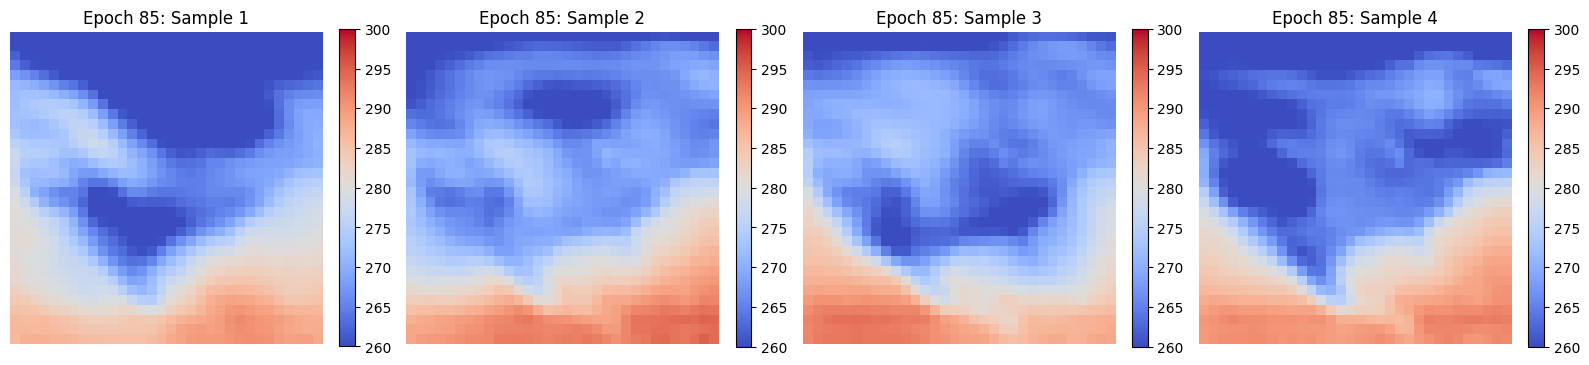

   ✓ Samples saved to checkpoints/samples/samples_epoch_085.png
--------------------------------------------------


Epoch 86/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 86/1000 [Train]:  80%|████████  | 74/92 [00:22<00:03,  5.87it/s, loss=0.2621]

⚠️ Warning: NaN in model predictions at batch 72, skipping...
⚠️ Warning: NaN in model predictions at batch 73, skipping...


Epoch 86/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 86/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.2173]



Epoch 86/1000:
  Train Loss: 0.288002
  Val Loss: 0.281713
  ✓ Saved best model (val_loss=0.281713)
--------------------------------------------------


Epoch 87/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 87/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 87/1


Epoch 87/1000:
  Train Loss: 0.282261
  Val Loss: 0.275129
  ✓ Saved best model (val_loss=0.275129)
--------------------------------------------------


Epoch 88/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 88/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 88/1


Epoch 88/1000:
  Train Loss: 0.280230
  Val Loss: 0.268709
  ✓ Saved best model (val_loss=0.268709)
--------------------------------------------------


Epoch 89/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 89/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 89/1


Epoch 89/1000:
  Train Loss: 0.282658
  Val Loss: 0.283995
--------------------------------------------------


Epoch 90/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 90/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 90/1


Epoch 90/1000:
  Train Loss: 0.260309
  Val Loss: 0.290004

🎨 Generating samples at epoch 90...



/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


   📊 Sample stats: min=246.961426, max=292.233643, mean=268.920319, std=10.249189


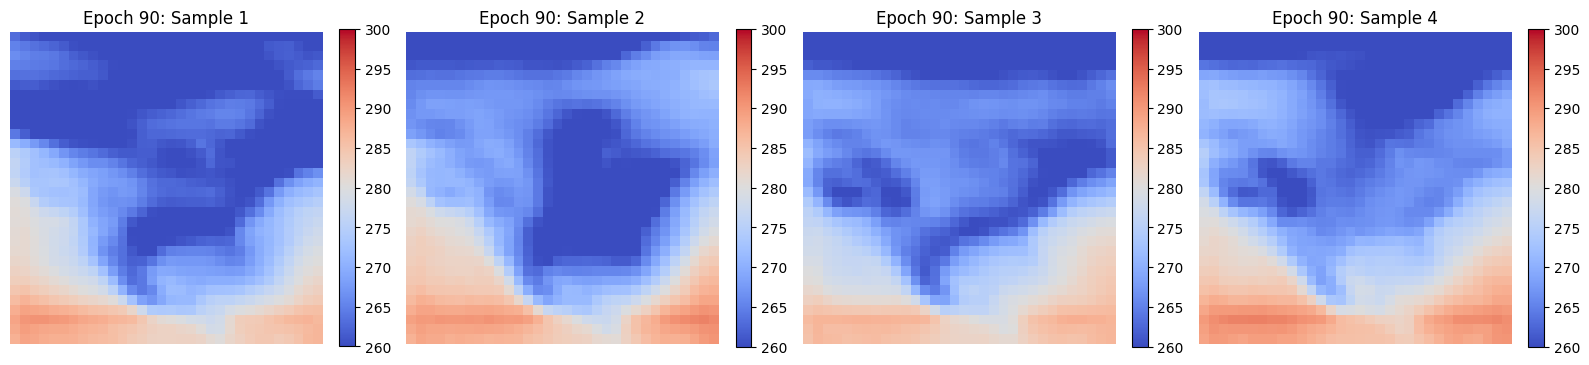

   ✓ Samples saved to checkpoints/samples/samples_epoch_090.png
--------------------------------------------------


Epoch 91/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 91/1000 [Train]:   1%|          | 1/92 [00:04<06:26,  4.24s/it, loss=0.3437]

⚠️ Warning: NaN in model predictions at batch 1, skipping...


Epoch 91/1000 [Train]:  24%|██▍       | 22/92 [00:09<00:17,  4.01it/s, loss=0.3852]

⚠️ Warning: NaN in model predictions at batch 22, skipping...


Epoch 91/1000 [Train]:  95%|█████████▍| 87/92 [00:25<00:01,  4.06it/s, loss=0.3876]

⚠️ Warning: NaN in model predictions at batch 87, skipping...


Epoch 91/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 91/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.2643]



Epoch 91/1000:
  Train Loss: 0.265444
  Val Loss: 0.265133
  ✓ Saved best model (val_loss=0.265133)
--------------------------------------------------


Epoch 92/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 92/1000 [Train]:  52%|█████▏    | 48/92 [00:15<00:11,  3.95it/s, loss=0.2523]

⚠️ Warning: NaN in model predictions at batch 48, skipping...


Epoch 92/1000 [Train]:  95%|█████████▍| 87/92 [00:25<00:01,  3.94it/s, loss=0.3166]

⚠️ Warning: NaN in model predictions at batch 87, skipping...


Epoch 92/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 92/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, loss=0.2987]



Epoch 92/1000:
  Train Loss: 0.266938
  Val Loss: 0.266573
--------------------------------------------------


Epoch 93/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 93/1000 [Train]:  25%|██▌       | 23/92 [00:09<00:17,  3.93it/s, loss=0.2220]

⚠️ Warning: NaN in model predictions at batch 23, skipping...


Epoch 93/1000 [Train]:  28%|██▊       | 26/92 [00:09<00:14,  4.43it/s, loss=0.2655]

⚠️ Warning: NaN in model predictions at batch 26, skipping...


Epoch 93/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 93/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, loss=0.2861]



Epoch 93/1000:
  Train Loss: 0.258269
  Val Loss: 0.237255
  ✓ Saved best model (val_loss=0.237255)
--------------------------------------------------


Epoch 94/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 94/1000 [Train]:   7%|▋         | 6/92 [00:04<00:37,  2.28it/s, loss=0.3526]

⚠️ Warning: NaN in model predictions at batch 6, skipping...


Epoch 94/1000 [Train]:  23%|██▎       | 21/92 [00:08<00:17,  3.94it/s, loss=0.2620]

⚠️ Warning: NaN in model predictions at batch 21, skipping...


Epoch 94/1000 [Train]:  37%|███▋      | 34/92 [00:11<00:14,  3.96it/s, loss=0.2292]

⚠️ Warning: NaN in model predictions at batch 34, skipping...


Epoch 94/1000 [Train]:  80%|████████  | 74/92 [00:21<00:04,  3.94it/s, loss=0.2860]

⚠️ Warning: NaN in model predictions at batch 74, skipping...


Epoch 94/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 94/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.2752]



Epoch 94/1000:
  Train Loss: 0.258937
  Val Loss: 0.258139
--------------------------------------------------


Epoch 95/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 95/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 95/1


Epoch 95/1000:
  Train Loss: 0.248468
  Val Loss: 0.267461

🎨 Generating samples at epoch 95...



/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


   📊 Sample stats: min=247.480865, max=293.223694, mean=268.239868, std=10.648969


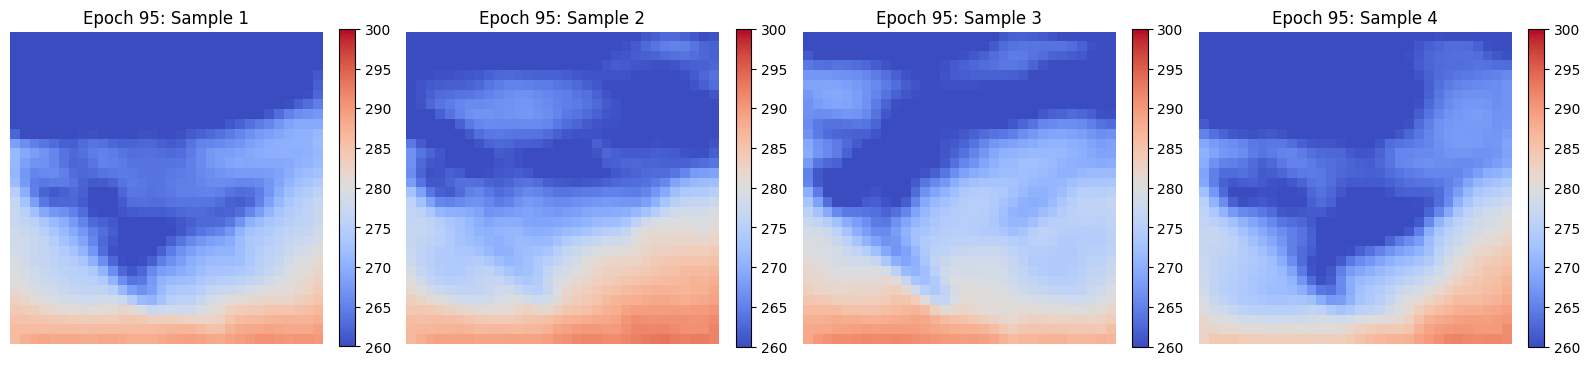

   ✓ Samples saved to checkpoints/samples/samples_epoch_095.png
--------------------------------------------------


Epoch 96/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 96/1000 [Train]:  28%|██▊       | 26/92 [00:10<00:16,  3.92it/s, loss=0.2116]

⚠️ Warning: NaN in model predictions at batch 26, skipping...


Epoch 96/1000 [Train]:  72%|███████▏  | 66/92 [00:20<00:06,  3.82it/s, loss=0.2626]

⚠️ Warning: NaN in model predictions at batch 66, skipping...


Epoch 96/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 96/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.2949]



Epoch 96/1000:
  Train Loss: 0.243940
  Val Loss: 0.268867
--------------------------------------------------


Epoch 97/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 97/1000 [Train]:  18%|█▊        | 17/92 [00:07<00:19,  3.91it/s, loss=0.2249]

⚠️ Warning: NaN in model predictions at batch 17, skipping...


Epoch 97/1000 [Train]:  58%|█████▊    | 53/92 [00:16<00:10,  3.85it/s, loss=0.2090]

⚠️ Warning: NaN in model predictions at batch 53, skipping...


Epoch 97/1000 [Train]:  65%|██████▌   | 60/92 [00:18<00:08,  3.98it/s, loss=0.2244]

⚠️ Warning: NaN in model predictions at batch 60, skipping...


Epoch 97/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 97/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, loss=0.2676]



Epoch 97/1000:
  Train Loss: 0.241191
  Val Loss: 0.264675
--------------------------------------------------


Epoch 98/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 98/1000 [Train]:  15%|█▌        | 14/92 [00:07<00:20,  3.76it/s, loss=0.1675]

⚠️ Warning: NaN in model predictions at batch 14, skipping...


Epoch 98/1000 [Train]:  18%|█▊        | 17/92 [00:07<00:17,  4.40it/s, loss=0.2548]

⚠️ Warning: NaN in model predictions at batch 17, skipping...


Epoch 98/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 98/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.2918]



Epoch 98/1000:
  Train Loss: 0.237446
  Val Loss: 0.219903
  ✓ Saved best model (val_loss=0.219903)
--------------------------------------------------


Epoch 99/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 99/1000 [Train]:  62%|██████▏   | 57/92 [00:17<00:08,  3.92it/s, loss=0.1883]

⚠️ Warning: NaN in model predictions at batch 57, skipping...


Epoch 99/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 99/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, loss=0.2435]



Epoch 99/1000:
  Train Loss: 0.234086
  Val Loss: 0.238497
--------------------------------------------------


Epoch 100/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 100/1000 [Train]:  58%|█████▊    | 53/92 [00:16<00:09,  3.93it/s, loss=0.2926]

⚠️ Warning: NaN in model predictions at batch 53, skipping...


Epoch 100/1000 [Train]:  66%|██████▋   | 61/92 [00:18<00:07,  4.01it/s, loss=0.2045]

⚠️ Warning: NaN in model predictions at batch 61, skipping...


Epoch 100/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 100/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.54it/s, loss=0.2372]


Epoch 100/1000:
  Train Loss: 0.231091
  Val Loss: 0.237387

🎨 Generating samples at epoch 100...



/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


   📊 Sample stats: min=239.535889, max=294.302246, mean=270.930176, std=11.925116


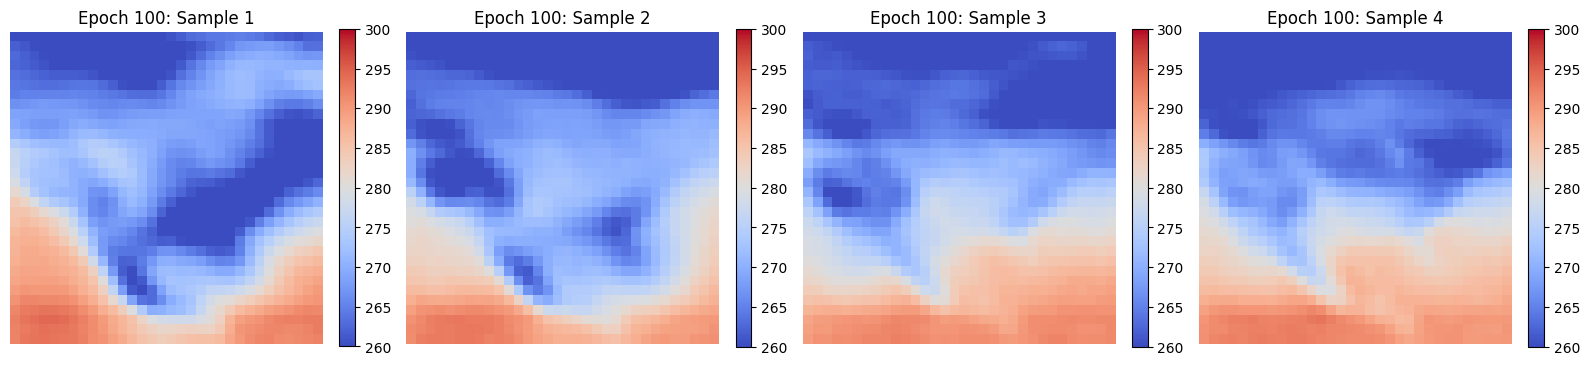

   ✓ Samples saved to checkpoints/samples/samples_epoch_100.png
--------------------------------------------------


Epoch 101/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 101/1000 [Train]:  40%|████      | 37/92 [00:12<00:13,  3.94it/s, loss=0.1667]

⚠️ Warning: NaN in model predictions at batch 37, skipping...


Epoch 101/1000 [Train]:  90%|█████████ | 83/92 [00:24<00:02,  3.94it/s, loss=0.2223]

⚠️ Warning: NaN in model predictions at batch 83, skipping...


Epoch 101/1000 [Train]:  92%|█████████▏| 85/92 [00:24<00:01,  4.76it/s, loss=0.2669]

⚠️ Warning: NaN in model predictions at batch 85, skipping...


Epoch 101/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 101/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.51it/s, loss=0.2261]



Epoch 101/1000:
  Train Loss: 0.235002
  Val Loss: 0.221749
--------------------------------------------------


Epoch 102/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 102/1000 [Train]:  42%|████▏     | 39/92 [00:13<00:13,  3.94it/s, loss=0.2053]

⚠️ Warning: NaN in model predictions at batch 39, skipping...


Epoch 102/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 102/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.53it/s, loss=0.1912]



Epoch 102/1000:
  Train Loss: 0.221385
  Val Loss: 0.213229
  ✓ Saved best model (val_loss=0.213229)
--------------------------------------------------


Epoch 103/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 103/1000 [Train]:  10%|▉         | 9/92 [00:05<00:26,  3.15it/s, loss=0.1689]

⚠️ Warning: NaN in model predictions at batch 9, skipping...


Epoch 103/1000 [Train]:  96%|█████████▌| 88/92 [00:25<00:01,  3.95it/s, loss=0.2811]

⚠️ Warning: NaN in model predictions at batch 88, skipping...


Epoch 103/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 103/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.53it/s, loss=0.2429]



Epoch 103/1000:
  Train Loss: 0.223478
  Val Loss: 0.197434
  ✓ Saved best model (val_loss=0.197434)
--------------------------------------------------


Epoch 104/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 104/1000 [Train]:  14%|█▍        | 13/92 [00:06<00:21,  3.72it/s, loss=0.1178]

⚠️ Warning: NaN in model predictions at batch 13, skipping...


Epoch 104/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 104/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.53it/s, loss=0.1775]



Epoch 104/1000:
  Train Loss: 0.221325
  Val Loss: 0.206930
--------------------------------------------------


Epoch 105/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 105/1000 [Train]:  70%|██████▉   | 64/92 [00:19<00:07,  3.93it/s, loss=0.1748]

⚠️ Warning: NaN in model predictions at batch 64, skipping...


Epoch 105/1000 [Train]:  92%|█████████▏| 85/92 [00:24<00:01,  3.92it/s, loss=0.2353]

⚠️ Warning: NaN in model predictions at batch 85, skipping...


Epoch 105/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 105/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.2119]


Epoch 105/1000:
  Train Loss: 0.213522
  Val Loss: 0.212078

🎨 Generating samples at epoch 105...



/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


   📊 Sample stats: min=242.508163, max=292.772186, mean=269.403076, std=10.572493


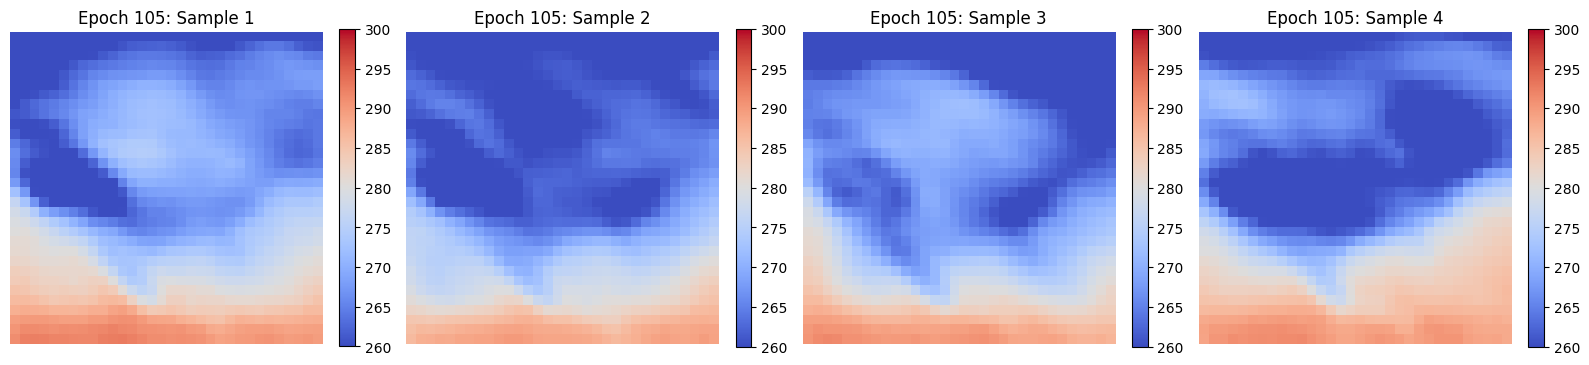

   ✓ Samples saved to checkpoints/samples/samples_epoch_105.png
--------------------------------------------------


Epoch 106/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 106/1000 [Train]:  63%|██████▎   | 58/92 [00:18<00:08,  3.94it/s, loss=0.1806]

⚠️ Warning: NaN in model predictions at batch 58, skipping...


Epoch 106/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 106/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.1851]



Epoch 106/1000:
  Train Loss: 0.209268
  Val Loss: 0.209063
--------------------------------------------------


Epoch 107/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 107/1000 [Train]:  55%|█████▌    | 51/92 [00:16<00:10,  3.92it/s, loss=0.1714]

⚠️ Warning: NaN in model predictions at batch 51, skipping...


Epoch 107/1000 [Train]:  73%|███████▎  | 67/92 [00:20<00:06,  3.95it/s, loss=0.2342]

⚠️ Warning: NaN in model predictions at batch 67, skipping...


Epoch 107/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 107/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.2342]



Epoch 107/1000:
  Train Loss: 0.204370
  Val Loss: 0.209285
--------------------------------------------------


Epoch 108/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 108/1000 [Train]:  34%|███▎      | 31/92 [00:12<00:15,  3.94it/s, loss=0.2250]

⚠️ Warning: NaN in model predictions at batch 31, skipping...


Epoch 108/1000 [Train]:  53%|█████▎    | 49/92 [00:16<00:10,  3.93it/s, loss=0.1933]

⚠️ Warning: NaN in model predictions at batch 49, skipping...


Epoch 108/1000 [Train]:  87%|████████▋ | 80/92 [00:24<00:03,  3.95it/s, loss=0.1827]

⚠️ Warning: NaN in model predictions at batch 80, skipping...


Epoch 108/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 108/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, loss=0.1734]



Epoch 108/1000:
  Train Loss: 0.200986
  Val Loss: 0.208461
--------------------------------------------------


Epoch 109/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 109/1000 [Train]:   9%|▊         | 8/92 [00:05<00:28,  2.95it/s, loss=0.0765]

⚠️ Warning: NaN in model predictions at batch 8, skipping...


Epoch 109/1000 [Train]:  32%|███▏      | 29/92 [00:10<00:15,  3.94it/s, loss=0.2823]

⚠️ Warning: NaN in model predictions at batch 29, skipping...


Epoch 109/1000 [Train]:  38%|███▊      | 35/92 [00:11<00:13,  4.12it/s, loss=0.1881]

⚠️ Warning: NaN in model predictions at batch 35, skipping...


Epoch 109/1000 [Train]:  46%|████▌     | 42/92 [00:13<00:12,  4.10it/s, loss=0.1971]

⚠️ Warning: NaN in model predictions at batch 42, skipping...


Epoch 109/1000 [Train]:  72%|███████▏  | 66/92 [00:19<00:06,  4.02it/s, loss=0.1593]

⚠️ Warning: NaN in model predictions at batch 66, skipping...


Epoch 109/1000 [Train]:  92%|█████████▏| 85/92 [00:23<00:01,  3.95it/s, loss=0.1336]

⚠️ Warning: NaN in model predictions at batch 85, skipping...


Epoch 109/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 109/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.1308]



Epoch 109/1000:
  Train Loss: 0.207599
  Val Loss: 0.207507
--------------------------------------------------


Epoch 110/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 110/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 11


Epoch 110/1000:
  Train Loss: 0.191850
  Val Loss: 0.201348

🎨 Generating samples at epoch 110...



/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


   📊 Sample stats: min=243.583801, max=294.875732, mean=270.157043, std=11.827947


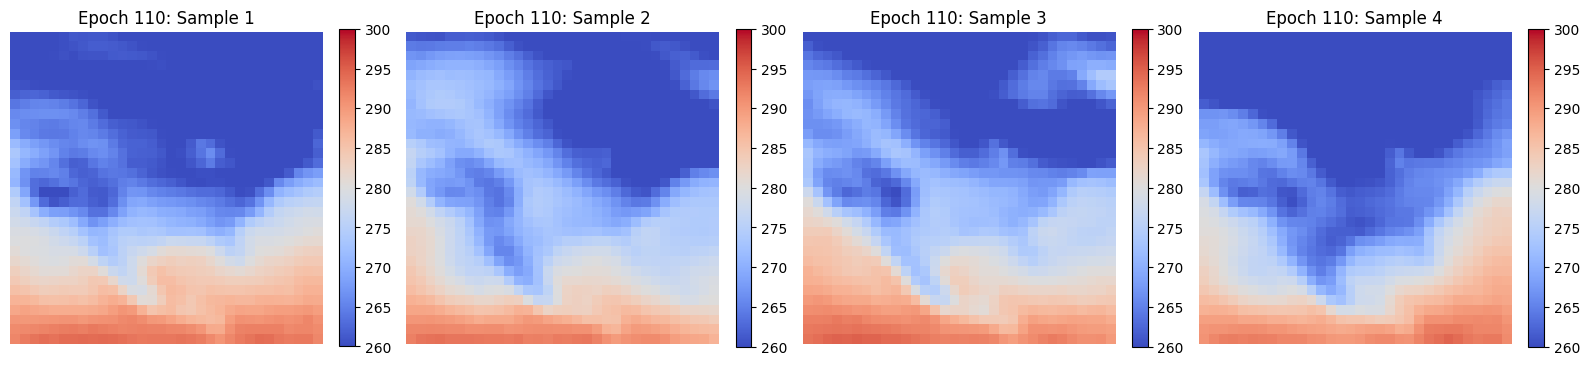

   ✓ Samples saved to checkpoints/samples/samples_epoch_110.png
--------------------------------------------------


Epoch 111/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 111/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 11


Epoch 111/1000:
  Train Loss: 0.187445
  Val Loss: 0.190633
  ✓ Saved best model (val_loss=0.190633)
--------------------------------------------------


Epoch 112/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 112/1000 [Train]:  38%|███▊      | 35/92 [00:12<00:14,  3.95it/s, loss=0.2440]

⚠️ Warning: NaN in model predictions at batch 35, skipping...


Epoch 112/1000 [Train]:  64%|██████▍   | 59/92 [00:18<00:08,  3.92it/s, loss=0.1844]

⚠️ Warning: NaN in model predictions at batch 59, skipping...


Epoch 112/1000 [Train]:  67%|██████▋   | 62/92 [00:18<00:06,  4.55it/s, loss=0.2362]

⚠️ Warning: NaN in model predictions at batch 62, skipping...


Epoch 112/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 112/1000 [Valid]: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s, loss=0.1781]



Epoch 112/1000:
  Train Loss: 0.190858
  Val Loss: 0.185718
  ✓ Saved best model (val_loss=0.185718)
--------------------------------------------------


Epoch 113/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 113/1000 [Train]:   7%|▋         | 6/92 [00:04<00:38,  2.26it/s, loss=0.1669]

⚠️ Warning: NaN in model predictions at batch 6, skipping...


Epoch 113/1000 [Train]:  18%|█▊        | 17/92 [00:07<00:19,  3.92it/s, loss=0.2066]

⚠️ Warning: NaN in model predictions at batch 17, skipping...


Epoch 113/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 113/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.52it/s, loss=0.1751]



Epoch 113/1000:
  Train Loss: 0.188586
  Val Loss: 0.178481
  ✓ Saved best model (val_loss=0.178481)
--------------------------------------------------


Epoch 114/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 114/1000 [Train]:  41%|████▏     | 38/92 [00:13<00:13,  3.87it/s, loss=0.2097]

⚠️ Warning: NaN in model predictions at batch 38, skipping...


Epoch 114/1000 [Valid]:   0%|          | 0/23 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 114/1000 [Valid]: 100%|██████████| 23/23 [00:15<00:00,  1.50it/s, loss=0.1795]



Epoch 114/1000:
  Train Loss: 0.178164
  Val Loss: 0.179464
--------------------------------------------------


Epoch 115/1000 [Train]:   0%|          | 0/92 [00:00<?, ?it/s]/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/manmeet.singh/Downloads/DeepAssimilate/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 115/1000 [Train]:  84%|████████▎ | 77/92 [00:22<00:03,  3.94it/s, loss=0.1736]

⚠️ Warning: NaN in model predictions at batch 77, skipping...


Epoch 115/1000 [Train]: 100%|██████████| 92/92 [00:34<00:00,  2.65it/s, loss=0.1714]


KeyboardInterrupt: 

In [32]:
# Training loop with validation
# This detailed loop includes validation, checkpointing, and progress tracking
# For a simpler approach, use da.train_unconditional() - see 'Next Steps' section
train_losses = []
val_losses = []

best_val_loss = float('inf')
checkpoint_dir = 'checkpoints'
samples_dir = os.path.join(checkpoint_dir, 'samples')  # Directory for sample visualizations
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(samples_dir, exist_ok=True)

# Visualization settings
visualize_every_n_epochs = 5  # Generate samples every N epochs (set to 1 for every epoch)
num_viz_samples = 4  # Number of samples to generate for visualization
num_viz_steps = 50  # Inference steps for visualization (fewer = faster)

print(f"📊 Visualization: Generating {num_viz_samples} samples every {visualize_every_n_epochs} epoch(s)")
print(f"   Samples will be saved to: {samples_dir}")

# CRITICAL: Initialize scheduler for training
# The HeunDiscreteScheduler needs set_timesteps() called before add_noise() works
# This ensures the scheduler is in the correct state for training
# Get num_train_timesteps from scheduler config (more reliable than using a variable)
original_num_train_timesteps = noise_scheduler.config.num_train_timesteps
print(f"\n🔧 Initializing scheduler for training (num_train_timesteps={original_num_train_timesteps})...")
noise_scheduler.set_timesteps(original_num_train_timesteps, device=device)
print(f"   ✓ Scheduler initialized and ready for training")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_train_losses = []

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for batch_idx, batch in enumerate(train_pbar):
        x = batch.to(device)  # [B, 1, H, W]

        # Check for NaN in input
        if torch.isnan(x).any():
            print(f"⚠️ Warning: NaN detected in input batch {batch_idx}, skipping...")
            continue

        # Map to [-1, 1] for EDM-style training
        x = x * 2.0 - 1.0

        # Clip to prevent extreme values
        x = torch.clamp(x, min=-3.0, max=3.0)

        # Sample random timesteps
        timesteps = torch.randint(
            0,
            noise_scheduler.num_train_timesteps,
            (x.shape[0],),
            device=device
        ).long()

        # Add noise
        noise = torch.randn_like(x)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Check for NaN after adding noise
        if torch.isnan(noisy_x).any():
            print(f"⚠️ Warning: NaN after adding noise in batch {batch_idx}, skipping...")
            continue

        # Predict noise
        pred_noise = model(noisy_x, timesteps).sample

        # Check for NaN in predictions
        if torch.isnan(pred_noise).any():
            print(f"⚠️ Warning: NaN in model predictions at batch {batch_idx}, skipping...")
            continue

        # Compute loss
        loss = loss_fn(pred_noise, noise)

        # Check for NaN in loss
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"⚠️ Warning: NaN/Inf loss detected at batch {batch_idx}, skipping...")
            continue

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Check for NaN gradients before clipping
        has_nan_grad = False
        for param in model.parameters():
            if param.grad is not None and torch.isnan(param.grad).any():
                has_nan_grad = True
                break

        if has_nan_grad:
            print(f"⚠️ Warning: NaN gradients detected at batch {batch_idx}, skipping update...")
            optimizer.zero_grad()  # Clear gradients
            continue

        # Gradient clipping (more aggressive to prevent instability)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        lr_scheduler.step()

        # Only track valid losses
        loss_value = loss.item()
        if not (np.isnan(loss_value) or np.isinf(loss_value)):
            epoch_train_losses.append(loss_value)
            train_pbar.set_postfix({'loss': f"{loss_value:.4f}"})
        else:
            train_pbar.set_postfix({'loss': 'NaN/Inf - skipped'})

    # Only compute average if we have valid losses
    if len(epoch_train_losses) > 0:
        avg_train_loss = np.mean(epoch_train_losses)
    else:
        print(f"⚠️ Warning: No valid training losses in epoch {epoch+1}, stopping training!")
        break

    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    epoch_val_losses = []

    with torch.no_grad():
        val_pbar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]")
        for batch in val_pbar:
            x = batch.to(device)
            x = x * 2.0 - 1.0
            x = torch.clamp(x, min=-3.0, max=3.0)  # Clip validation data too

            timesteps = torch.randint(
                0,
                noise_scheduler.num_train_timesteps,
                (x.shape[0],),
                device=device
            ).long()

            noise = torch.randn_like(x)
            noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
            pred_noise = model(noisy_x, timesteps).sample
            loss = loss_fn(pred_noise, noise)

            loss_value = loss.item()
            if not (np.isnan(loss_value) or np.isinf(loss_value)):
                epoch_val_losses.append(loss_value)
                val_pbar.set_postfix({'loss': f"{loss_value:.4f}"})

    # Only compute average if we have valid losses
    if len(epoch_val_losses) > 0:
        avg_val_loss = np.mean(epoch_val_losses)
    else:
        print(f"⚠️ Warning: No valid validation losses in epoch {epoch+1}")
        avg_val_loss = float('inf')

    val_losses.append(avg_val_loss)

    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {avg_train_loss:.6f}")
    print(f"  Val Loss: {avg_val_loss:.6f}")

    # Check if loss is still valid before saving
    if not (np.isnan(avg_val_loss) or np.isinf(avg_val_loss)) and avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': avg_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses,
        }, checkpoint_path)
        print(f"  ✓ Saved best model (val_loss={avg_val_loss:.6f})")
    elif np.isnan(avg_val_loss) or np.isinf(avg_val_loss):
        print(f"  ⚠️ Warning: Invalid loss detected, not saving model")

    # Early stopping if loss becomes NaN
    if np.isnan(avg_train_loss) or np.isinf(avg_train_loss):
        print(f"\n⚠️ Training stopped due to NaN/Inf loss at epoch {epoch+1}")
        print("   Try: reducing learning rate, checking data normalization, or reducing model size")
        break

    # Generate and visualize samples periodically
    # Skip epoch 0 - model is untrained and will likely produce NaN/invalid samples
    if (epoch + 1) % visualize_every_n_epochs == 0 or (epoch == num_epochs - 1 and epoch > 0):
        print(f"\n🎨 Generating samples at epoch {epoch+1}...")
        try:
            # Get image dimensions from a sample batch
            sample_check = next(iter(train_loader))
            _, _, viz_img_h, viz_img_w = sample_check.shape

            # Get data normalization range (if available in scope)
            try:
                viz_data_min = data_min
                viz_data_max = data_max
            except NameError:
                viz_data_min = None
                viz_data_max = None

            generate_and_visualize_samples_v2(
                model=model,
                scheduler=noise_scheduler,
                device=device,
                num_samples=num_viz_samples,
                num_inference_steps=num_viz_steps,
                img_h=viz_img_h,
                img_w=viz_img_w,
                data_min=viz_data_min,
                data_max=viz_data_max,
                epoch=epoch,
                save_dir=samples_dir
            )

            # CRITICAL: Restore scheduler to training state after visualization
            # This prevents IndexError when training resumes
            # Use the stored original_num_train_timesteps from the start of training
            noise_scheduler.set_timesteps(original_num_train_timesteps, device=device)

            print(f"   ✓ Samples saved to {samples_dir}/samples_epoch_{epoch+1:03d}.png")
        except Exception as e:
            print(f"   ⚠️ Warning: Could not generate samples: {e}")
            print("   Continuing training...")

    print('-' * 50)

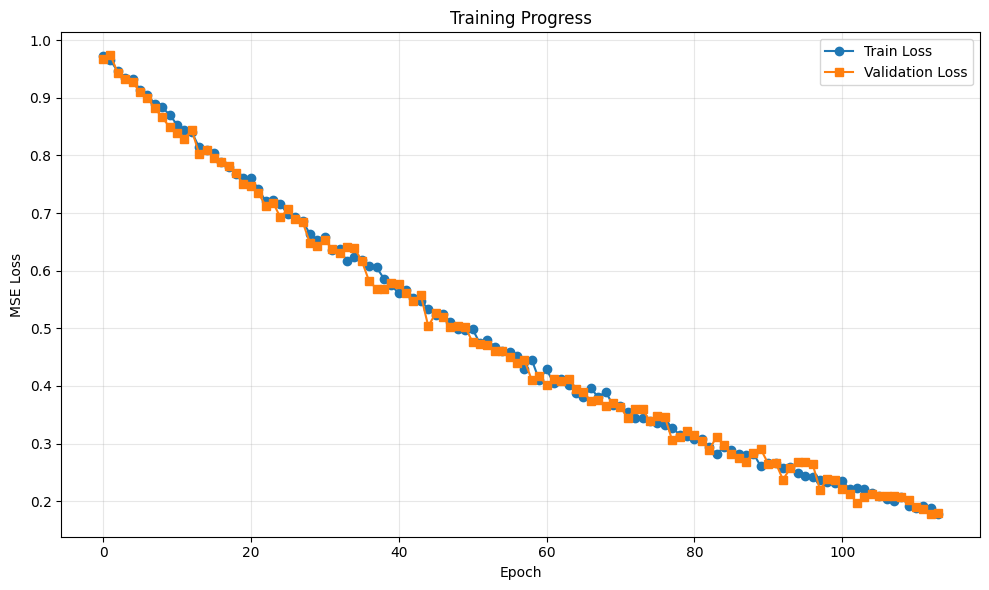

In [33]:
# Plot training curves
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train_losses, label='Train Loss', marker='o')
ax.plot(val_losses, label='Validation Loss', marker='s')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Training Progress')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 6. Sampling from the Trained Model

Now we'll generate new samples by starting from pure noise and iteratively denoising using the trained model.


In [36]:
# Load best model

checkpoint = torch.load(
    os.path.join(checkpoint_dir, "best_model.pth"),
    weights_only=False,
)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Loaded model from epoch {checkpoint['epoch']+1} with val_loss={checkpoint['val_loss']:.6f}")


Loaded model from epoch 113 with val_loss=0.178481


In [40]:
# Generate samples
num_inference_steps = 50  # Number of denoising steps (can be reduced for faster sampling)
num_samples = 4

model.eval()

# Set timesteps for inference
noise_scheduler.set_timesteps(num_inference_steps, device=device)

# Start from random noise
sample_shape = (num_samples, 1, img_h, img_w)
samples = torch.randn(sample_shape, device=device)

# Denoising loop with NaN protection
with torch.no_grad():
    for t in tqdm(noise_scheduler.timesteps, desc="Sampling"):
        # Expand timestep to batch size
        timestep = t.expand(samples.shape[0])

        # Predict noise
        noise_pred = model(samples, timestep).sample
        if torch.isnan(noise_pred).any():
            noise_pred = torch.nan_to_num(noise_pred, nan=0.0)

        # Step scheduler
        samples = noise_scheduler.step(noise_pred, t, samples).prev_sample
        if torch.isnan(samples).any():
            samples = torch.nan_to_num(samples, nan=0.0)

# Map back to [0, 1] and then to original scale
samples = (samples + 1.0) / 2.0  # [-1, 1] -> [0, 1]
samples = samples * (data_max - data_min) + data_min  # Denormalize
samples = torch.nan_to_num(samples, nan=0.0)

print(f"Generated {num_samples} samples")
print(f"Sample value range: [{samples.min():.2f}, {samples.max():.2f}]")


Sampling: 100%|██████████| 99/99 [00:01<00:00, 53.96it/s]

Generated 4 samples
Sample value range: [242.65, 292.52]


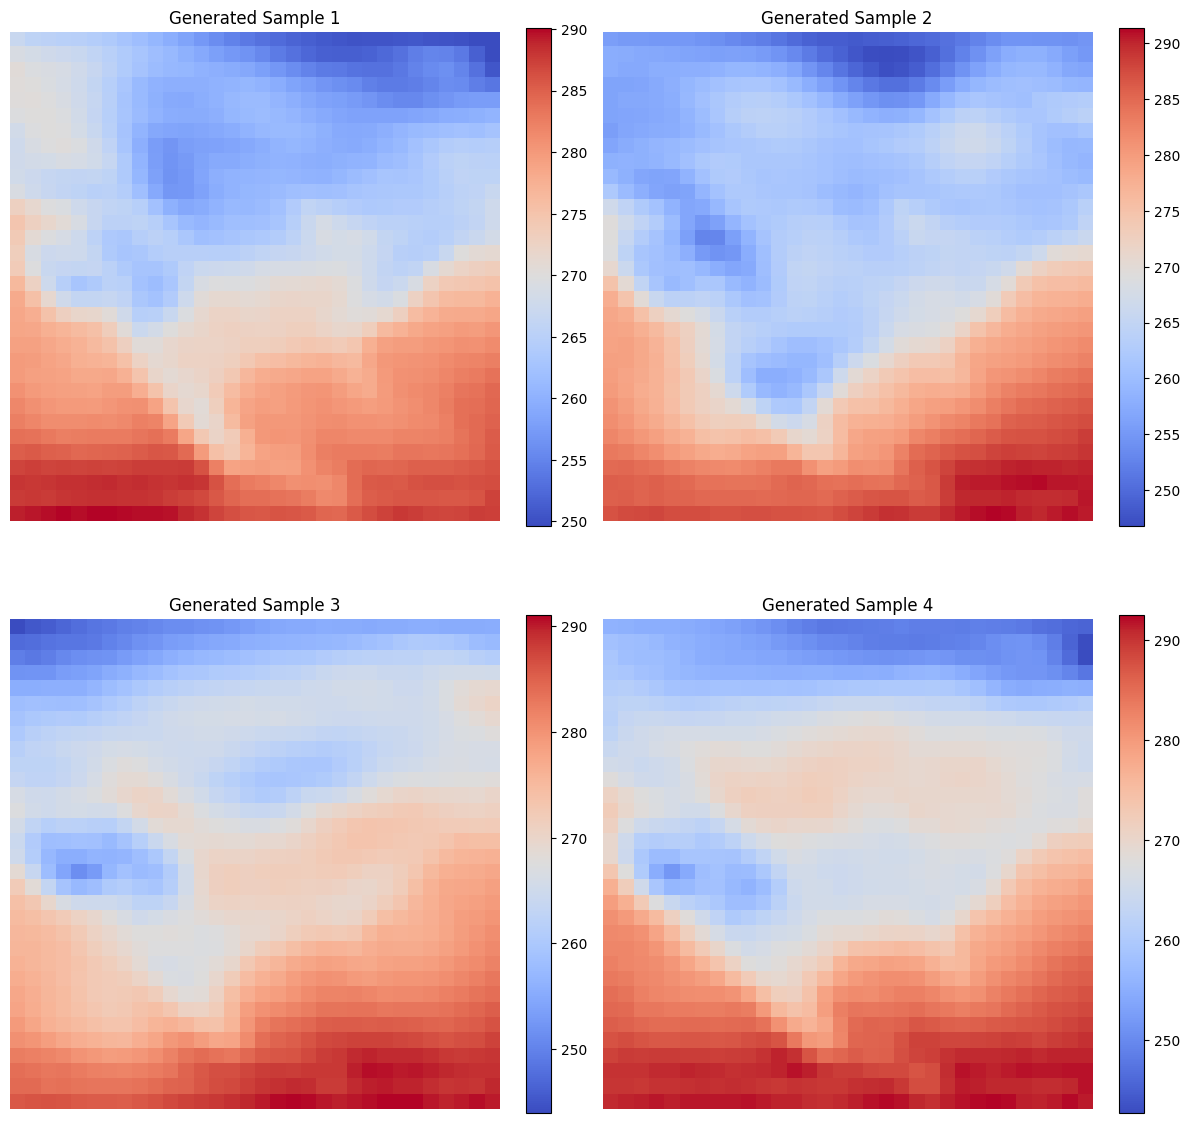

In [41]:
# Visualize generated samples
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

for i in range(num_samples):
    im = axs[i].imshow(samples[i, 0].cpu().numpy(), cmap='coolwarm')
    axs[i].set_title(f'Generated Sample {i+1}')
    axs[i].axis('off')
    plt.colorbar(im, ax=axs[i], fraction=0.046)

plt.tight_layout()
plt.show()


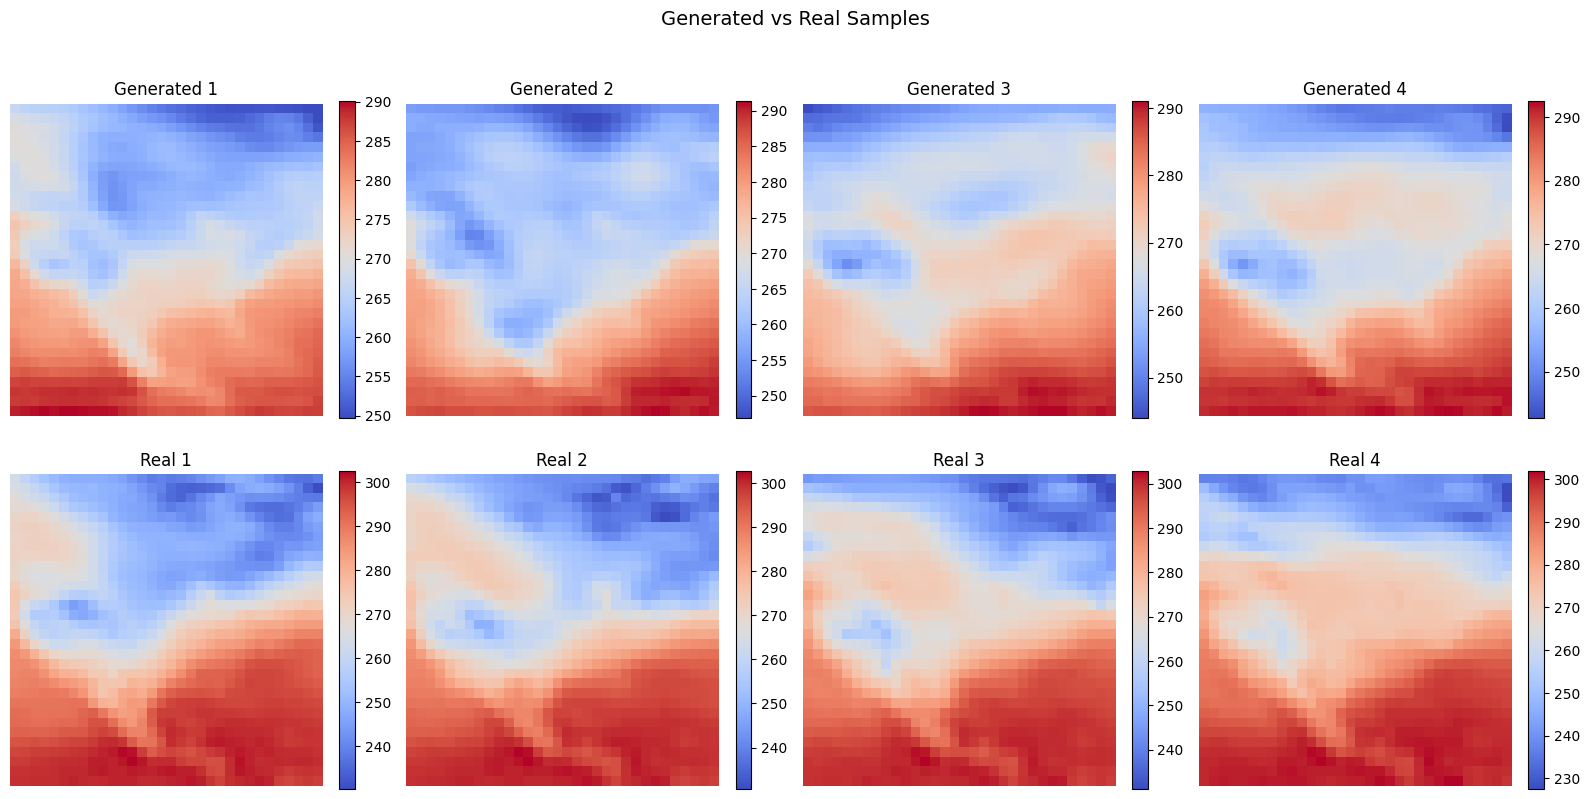

In [44]:
# Compare with real data
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

# Real samples from test set
real_samples_tensor = torch.stack([test_dataset[i] for i in range(num_samples)])
real_samples_tensor = real_samples_tensor * (data_max - data_min) + data_min

for i in range(num_samples):
    # Generated
    im1 = axs[0, i].imshow(samples[i, 0].cpu().numpy(), cmap='coolwarm')
    axs[0, i].set_title(f'Generated {i+1}')
    axs[0, i].axis('off')
    plt.colorbar(im1, ax=axs[0, i], fraction=0.046)

    # Real
    im2 = axs[1, i].imshow(real_samples_tensor[i, 0].cpu().numpy(), cmap='coolwarm')
    axs[1, i].set_title(f'Real {i+1}')
    axs[1, i].axis('off')
    plt.colorbar(im2, ax=axs[1, i], fraction=0.046)

plt.suptitle('Generated vs Real Samples', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


## 7. Next Steps

Congratulations! You've trained a diffusion model on weather data. Here are some next steps:

1. **Generative Data Assimilation**: Use the trained model with observations to improve initial conditions. See the `02_generative_data_assimilation.ipynb` notebook.

2. **Experiment with Different Regions**: Train models on different regions (Europe, global, etc.) or different variables (precipitation, winds, etc.).

3. **Architecture Improvements**: Try different UNet configurations, add attention mechanisms, or experiment with Diffusion Transformers (DiT).

4. **Distillation**: Use scheduler-only distillation to reduce inference timesteps for faster sampling.

5. **Evaluation Metrics**: Add quantitative evaluation (e.g., distribution statistics, spatial correlation, spectral properties).

6. **High-Resolution Models**: Extend to higher resolutions using latent diffusion models or tile-based approaches.

## Using deepassimilate Library

You can also use the `deepassimilate` library's training function for a more streamlined workflow:

```python
import deepassimilate as da

cfg = da.UncondTrainConfig(
    architecture="edm_unet_2d",
    scheduler="heun_edm",
    img_size=64,
    channels=1,
    num_epochs=20,
    batch_size=16,
    lr=1e-4,
    device="cuda"
)

model, scheduler, distilled_steps = da.train_unconditional(
    dataset=train_dataset,
    cfg=cfg
)
```
